Data Scientist: John Pan

In [3]:
import pandas as pd
import numpy as np
import os
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import warnings     # for supressing a warning when importing large files
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

LABELS = ["Normal", "Fraud"]

In [4]:
os.chdir(r'H:\Medical Fraud\MedicalCostPrediction-insurance_fraudDetection-master\MedicalCostPrediction-insurance_fraudDetection-master\data')

In [5]:
# Load Train Dataset

Train=pd.read_csv("Train-1542865627584.csv")
Train_Beneficiarydata=pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
Train_Inpatientdata=pd.read_csv("Train_Inpatientdata-1542865627584.csv")
Train_Outpatientdata=pd.read_csv("Train_Outpatientdata-1542865627584.csv")

# Load Test Dataset

Test=pd.read_csv("Test-1542969243754.csv")
Test_Beneficiarydata=pd.read_csv("Test_Beneficiarydata-1542969243754.csv")
Test_Inpatientdata=pd.read_csv("Test_Inpatientdata-1542969243754.csv")
Test_Outpatientdata=pd.read_csv("Test_Outpatientdata-1542969243754.csv")

In [6]:
## Lets check shape of Train and Test Data

print('Train Shape:',Train.shape,'\n')
print('Train Sample:\n',Train.head(2),'\n')

print('\n Test Shape:',Test.shape,'\n')
print('Test Sample: \n',Test.head(2))

Train Shape: (5410, 2) 

Train Sample:
    Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes 


 Test Shape: (1353, 1) 

Test Sample: 
    Provider
0  PRV51002
1  PRV51006


In [7]:
## Lets check whether  providers details are unique or not in train data
print(Train.Provider.value_counts(sort=True,ascending=False).head(2))  # number of unique providers in train data.Check for duplicates

print('\n Total missing values in Train :',Train.isna().sum().sum())

print('\n Total missing values in Train :',Test.isna().sum().sum())

PRV53392    1
PRV57006    1
Name: Provider, dtype: int64

 Total missing values in Train : 0

 Total missing values in Train : 0


In [8]:
#Lets Check missing values in each column in beneficiary data :

Train_Beneficiarydata.isna().sum()
Test_Beneficiarydata.isna().sum()

BeneID                                 0
DOB                                    0
DOD                                63394
Gender                                 0
Race                                   0
RenalDiseaseIndicator                  0
State                                  0
County                                 0
NoOfMonths_PartACov                    0
NoOfMonths_PartBCov                    0
ChronicCond_Alzheimer                  0
ChronicCond_Heartfailure               0
ChronicCond_KidneyDisease              0
ChronicCond_Cancer                     0
ChronicCond_ObstrPulmonary             0
ChronicCond_Depression                 0
ChronicCond_Diabetes                   0
ChronicCond_IschemicHeart              0
ChronicCond_Osteoporasis               0
ChronicCond_rheumatoidarthritis        0
ChronicCond_stroke                     0
IPAnnualReimbursementAmt               0
IPAnnualDeductibleAmt                  0
OPAnnualReimbursementAmt               0
OPAnnualDeductib

In [9]:
# Lets check data types of each column in beneficiary data

Train_Beneficiarydata.dtypes
Test_Beneficiarydata.dtypes

BeneID                             object
DOB                                object
DOD                                object
Gender                              int64
Race                                int64
RenalDiseaseIndicator              object
State                               int64
County                              int64
NoOfMonths_PartACov                 int64
NoOfMonths_PartBCov                 int64
ChronicCond_Alzheimer               int64
ChronicCond_Heartfailure            int64
ChronicCond_KidneyDisease           int64
ChronicCond_Cancer                  int64
ChronicCond_ObstrPulmonary          int64
ChronicCond_Depression              int64
ChronicCond_Diabetes                int64
ChronicCond_IschemicHeart           int64
ChronicCond_Osteoporasis            int64
ChronicCond_rheumatoidarthritis     int64
ChronicCond_stroke                  int64
IPAnnualReimbursementAmt            int64
IPAnnualDeductibleAmt               int64
OPAnnualReimbursementAmt          

In [10]:
##Replacing 2 with 0 for chronic conditions ,that means chroniv condition No is 0 and yes is 1

Train_Beneficiarydata = Train_Beneficiarydata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Train_Beneficiarydata = Train_Beneficiarydata.replace({'RenalDiseaseIndicator': 'Y'}, 1)

Test_Beneficiarydata = Test_Beneficiarydata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Test_Beneficiarydata = Test_Beneficiarydata.replace({'RenalDiseaseIndicator': 'Y'}, 1)

In [11]:
Train_Beneficiarydata.head(1)
Test_Beneficiarydata.head(1)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,0,1,1,36000,3204,60,70


Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)

In [12]:
## Lets Create Age column to the dataset

Train_Beneficiarydata['DOB'] = pd.to_datetime(Train_Beneficiarydata['DOB'] , format = '%Y-%m-%d')
Train_Beneficiarydata['DOD'] = pd.to_datetime(Train_Beneficiarydata['DOD'],format = '%Y-%m-%d',errors='ignore')
Train_Beneficiarydata['Age'] = round(((Train_Beneficiarydata['DOD'] - Train_Beneficiarydata['DOB']).dt.days)/365)


Test_Beneficiarydata['DOB'] = pd.to_datetime(Test_Beneficiarydata['DOB'] , format = '%Y-%m-%d')
Test_Beneficiarydata['DOD'] = pd.to_datetime(Test_Beneficiarydata['DOD'],format = '%Y-%m-%d',errors='ignore')
Test_Beneficiarydata['Age'] = round(((Test_Beneficiarydata['DOD'] - Test_Beneficiarydata['DOB']).dt.days)/365)

In [13]:
## As we see that last DOD value is 2009-12-01 ,which means Beneficiary Details data is of year 2009.
## so we will calculate age of other benficiaries for year 2009.

Train_Beneficiarydata.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Train_Beneficiarydata['DOB']).dt.days)/365),
                                 inplace=True)


Test_Beneficiarydata.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Test_Beneficiarydata['DOB']).dt.days)/365),
                                 inplace=True)

In [14]:
Train_Beneficiarydata.head(2)
Test_Beneficiarydata.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,1,0,1,1,36000,3204,60,70,67.0
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,1,0,1,1,0,0,0,1490,160,69.0


Add Flag column 'WhetherDead' using DOD values to tell whether beneficiary is dead on not

In [15]:
#Lets create a new variable 'WhetherDead' with flag 1 means Dead and 0 means not Dead

Train_Beneficiarydata.loc[Train_Beneficiarydata.DOD.isna(),'WhetherDead']=0
Train_Beneficiarydata.loc[Train_Beneficiarydata.DOD.notna(),'WhetherDead']=1
Train_Beneficiarydata.loc[:,'WhetherDead'].head(7)


Test_Beneficiarydata.loc[Test_Beneficiarydata.DOD.isna(),'WhetherDead']=0
Test_Beneficiarydata.loc[Test_Beneficiarydata.DOD.notna(),'WhetherDead']=1
Test_Beneficiarydata.loc[:,'WhetherDead'].head(3)

0    0.0
1    1.0
2    0.0
Name: WhetherDead, dtype: float64

In [16]:
#Lets check missing values in each column in inpatient data
Train_Inpatientdata.isna().sum()

Test_Inpatientdata.isna().sum()

BeneID                       0
ClaimID                      0
ClaimStartDt                 0
ClaimEndDt                   0
Provider                     0
InscClaimAmtReimbursed       0
AttendingPhysician          31
OperatingPhysician        3962
OtherPhysician            8538
AdmissionDt                  0
ClmAdmitDiagnosisCode        0
DeductibleAmtPaid          196
DischargeDt                  0
DiagnosisGroupCode           0
ClmDiagnosisCode_1           0
ClmDiagnosisCode_2          54
ClmDiagnosisCode_3         169
ClmDiagnosisCode_4         404
ClmDiagnosisCode_5         719
ClmDiagnosisCode_6        1197
ClmDiagnosisCode_7        1736
ClmDiagnosisCode_8        2360
ClmDiagnosisCode_9        3238
ClmDiagnosisCode_10       8664
ClmProcedureCode_1        4118
ClmProcedureCode_2        8297
ClmProcedureCode_3        9328
ClmProcedureCode_4        9522
ClmProcedureCode_5        9549
ClmProcedureCode_6        9551
dtype: int64

Create new column 'AdmitForDays' indicating number of days patient was admitted in hospital

In [18]:
## As patient can be admitted for only for 1 day,we will add 1 to the difference of Discharge Date and Admission Date 

Train_Inpatientdata['AdmissionDt'] = pd.to_datetime(Train_Inpatientdata['AdmissionDt'] , format = '%Y-%m-%d')
Train_Inpatientdata['DischargeDt'] = pd.to_datetime(Train_Inpatientdata['DischargeDt'],format = '%Y-%m-%d')
Train_Inpatientdata['AdmitForDays'] = ((Train_Inpatientdata['DischargeDt'] - Train_Inpatientdata['AdmissionDt']).dt.days)+1


Test_Inpatientdata['AdmissionDt'] = pd.to_datetime(Test_Inpatientdata['AdmissionDt'] , format = '%Y-%m-%d')
Test_Inpatientdata['DischargeDt'] = pd.to_datetime(Test_Inpatientdata['DischargeDt'],format = '%Y-%m-%d')
Test_Inpatientdata['AdmitForDays'] = ((Test_Inpatientdata['DischargeDt'] - Test_Inpatientdata['AdmissionDt']).dt.days)+1

In [19]:
## Lets check Min and Max values of AdmitforDays column in Train and Test.
print('Min AdmitForDays Train:- ',Train_Inpatientdata.AdmitForDays.min())
print('Max AdmitForDays Train:- ',Train_Inpatientdata.AdmitForDays.max())
Train_Inpatientdata.AdmitForDays.isnull().sum()   #Check Null values.

print('Min AdmitForDays Test:- ',Test_Inpatientdata.AdmitForDays.min())
print('Max AdmitForDays Test:- ',Test_Inpatientdata.AdmitForDays.max())
Test_Inpatientdata.AdmitForDays.isnull().sum()   #Check Null values.

Min AdmitForDays Train:-  1
Max AdmitForDays Train:-  36
Min AdmitForDays Test:-  1
Max AdmitForDays Test:-  36


0

Outpatient Data understanding

Lets Check null values in each columnn of outpatient data

In [21]:
Train_Outpatientdata.isna().sum()

Test_Outpatientdata.isna().sum()

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician           316
OperatingPhysician        104237
OtherPhysician             78222
ClmDiagnosisCode_1          2578
ClmDiagnosisCode_2         47731
ClmDiagnosisCode_3         76575
ClmDiagnosisCode_4         95371
ClmDiagnosisCode_5        107875
ClmDiagnosisCode_6        114035
ClmDiagnosisCode_7        117871
ClmDiagnosisCode_8        120310
ClmDiagnosisCode_9        122278
ClmDiagnosisCode_10       125578
ClmProcedureCode_1        125807
ClmProcedureCode_2        125832
ClmProcedureCode_3        125839
ClmProcedureCode_4        125841
ClmProcedureCode_5        125841
ClmProcedureCode_6        125841
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     100036
dtype: int64

In [22]:
## Lets Check Shape of datasets after adding new variables

print('Shape of Train data :',Train.shape)
print('Shape of Train_Beneficiarydata data :',Train_Beneficiarydata.shape)
print('Shape of Train_Inpatientdata data :',Train_Inpatientdata.shape)
print('Shape of Train_Outpatientdata data :',Train_Outpatientdata.shape)

print('Shape of Test data :',Test.shape)
print('Shape of Test_Beneficiarydata data :',Test_Beneficiarydata.shape)
print('Shape of Test_Inpatientdata data :',Test_Inpatientdata.shape)
print('Shape of Test_Outpatientdata data :',Test_Outpatientdata.shape)

Shape of Train data : (5410, 2)
Shape of Train_Beneficiarydata data : (138556, 27)
Shape of Train_Inpatientdata data : (40474, 31)
Shape of Train_Outpatientdata data : (517737, 27)
Shape of Test data : (1353, 1)
Shape of Test_Beneficiarydata data : (63968, 27)
Shape of Test_Inpatientdata data : (9551, 31)
Shape of Test_Outpatientdata data : (125841, 27)


Data Merging


As we see columns in inpatient and outpatient data are similar, we will merge this data based on these similar keys using outer join.

In [23]:
Key_Column_To_Merge_Outpatient=Train_Outpatientdata.columns
print(Key_Column_To_Merge_Outpatient)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


Merge Inpatient and Outpatinet data and create dataset for all patients.

In [24]:
# Lets make union of Inpatienta and outpatient data .
# We will use all keys in outpatient data as we want to make union and dont want duplicate columns from both tables.

Train_Allpatientdata=pd.merge(Train_Outpatientdata,Train_Inpatientdata,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')


In [25]:
Test_Allpatientdata=pd.merge(Test_Outpatientdata,Test_Inpatientdata,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')

In [26]:
print('Train_Allpatientdata',Train_Allpatientdata.shape)
print('Test_Allpatientdata',Test_Allpatientdata.shape)

Train_Allpatientdata (558211, 31)
Test_Allpatientdata (135392, 31)


In [27]:
Train_Allpatientdata.head(4)
Test_Allpatientdata.head(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,AdmissionDt,DischargeDt,DiagnosisGroupCode,AdmitForDays
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,NaN,NaN,NaN,NaN,0.0,NaN,NaT,NaT,NaN,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,NaN,NaN,NaN,NaN,0.0,NaN,NaT,NaT,NaN,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,NaN,NaN,NaN,NaN,0.0,NaN,NaT,NaT,NaN,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,NaN,NaN,NaN,NaN,0.0,5939,NaT,NaT,NaN,NaN


Merge Beneficiary details to All Patients data

In [28]:
## Lets merge All patient data with beneficiary details data based on 'BeneID' as joining key for inner join
Train_AllPatientDetailsdata=pd.merge(Train_Allpatientdata,Train_Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')

Test_AllPatientDetailsdata=pd.merge(Test_Allpatientdata,Test_Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')

In [29]:
## Lets Print shape of data 
print('Shape of All Patient Details Train : ',Train_AllPatientDetailsdata.shape)
Train_AllPatientDetailsdata.head()

print('Shape of All Patient Details Test : ',Test_AllPatientDetailsdata.shape)
Test_AllPatientDetailsdata.head(2)

Shape of All Patient Details Train :  (558211, 57)
Shape of All Patient Details Test :  (135392, 57)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,1,0,1,1,36000,3204,60,70,67.0,0.0
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,1,0,1,1,36000,3204,60,70,67.0,0.0


Merge PotentialFraud details for each provider to create ProviderWithPatientDetails data

In [30]:
# Lets merge patient data with fradulent providers details data with "Provider" as joining key for inner join

Train_ProviderWithPatientDetailsdata=pd.merge(Train,Train_AllPatientDetailsdata,on='Provider')

Test_ProviderWithPatientDetailsdata=pd.merge(Test,Test_AllPatientDetailsdata,on='Provider')

In [31]:
## Lets Print the shape of dataset 
print("Shape of Train Provider with Patient Details data :-",Train_ProviderWithPatientDetailsdata.shape)
Train_ProviderWithPatientDetailsdata.head()

print("Shape of Test Provider with Patient Details data :-",Test_ProviderWithPatientDetailsdata.shape)
Test_ProviderWithPatientDetailsdata.head(2)

Shape of Train Provider with Patient Details data :- (558211, 58)
Shape of Test Provider with Patient Details data :- (135392, 57)


,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,PRV51002,BENE13342,CLM129901,2009-01-10,2009-01-10,100,PHY418314,PHY418314,PHY413853,514,...,0,0,0,0,0,0,1310,590,75.0,0.0
1,PRV51002,BENE13915,CLM163936,2009-01-29,2009-01-29,40,PHY399539,PHY421140,NaN,7840,...,1,0,0,0,22000,3204,1020,910,89.0,0.0


In [32]:
### Lets check missing value percentage in full datasets

#print('Percent missing values in Train Provider with patient details data :\n')
Train_ProviderWithPatientDetailsdata.isnull().sum()*100/len(Train_ProviderWithPatientDetailsdata)


print('Percent missing values in Test Provider with patient details data :\n')
Test_ProviderWithPatientDetailsdata.isnull().sum()*100/len(Test_ProviderWithPatientDetailsdata)

Percent missing values in Test Provider with patient details data :



Provider                             0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt                           0.000000
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.256293
OperatingPhysician                  79.915357
OtherPhysician                      64.080596
ClmDiagnosisCode_1                   1.904101
ClmDiagnosisCode_2                  35.293814
ClmDiagnosisCode_3                  56.682817
ClmDiagnosisCode_4                  70.739039
ClmDiagnosisCode_5                  80.207102
ClmDiagnosisCode_6                  85.109903
ClmDiagnosisCode_7                  88.341261
ClmDiagnosisCode_8                  90.603581
ClmDiagnosisCode_9                  92.705625
ClmDiagnosisCode_10                 99.150615
ClmProcedureCode_1                  95.962095
ClmProcedureCode_2                  99.067153
ClmProcedureCode_3                

In [33]:
## Lets Check dtypes of both the datasets
Train_ProviderWithPatientDetailsdata.dtypes
Test_ProviderWithPatientDetailsdata.dtypes

Provider                                   object
BeneID                                     object
ClaimID                                    object
ClaimStartDt                               object
ClaimEndDt                                 object
InscClaimAmtReimbursed                      int64
AttendingPhysician                         object
OperatingPhysician                         object
OtherPhysician                             object
ClmDiagnosisCode_1                         object
ClmDiagnosisCode_2                         object
ClmDiagnosisCode_3                         object
ClmDiagnosisCode_4                         object
ClmDiagnosisCode_5                         object
ClmDiagnosisCode_6                         object
ClmDiagnosisCode_7                         object
ClmDiagnosisCode_8                         object
ClmDiagnosisCode_9                         object
ClmDiagnosisCode_10                        object
ClmProcedureCode_1                        float64


Exploratory Data Analysis


Plot Potential fraud class proportion in both Train and Merged data

Percent Distribution of Potential Fraud class:- 
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


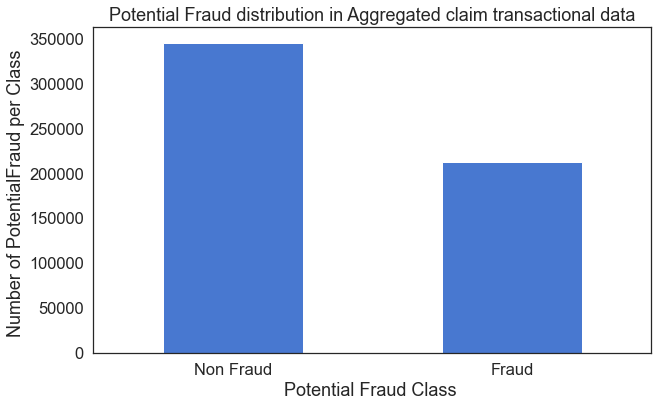

In [35]:
#PLotting the frequencies of fraud and non-fraud Merged transactions in the data

sns.set_style('white',rc={'figure.figsize':(12,8)})
count_classes = pd.value_counts(Train_ProviderWithPatientDetailsdata['PotentialFraud'], sort = True)
print("Percent Distribution of Potential Fraud class:- \n",count_classes*100/len(Train_ProviderWithPatientDetailsdata))
LABELS = ["Non Fraud", "Fraud"]
#Drawing a barplot
count_classes.plot(kind = 'bar', rot=0,figsize=(10,6))

#Giving titles and labels to the plot
plt.title("Potential Fraud distribution in Aggregated claim transactional data")
plt.xticks(range(2), LABELS)
plt.xlabel("Potential Fraud Class ")
plt.ylabel("Number of PotentialFraud per Class ")

plt.savefig('PotentialFraudDistributionInMergedData')

Percent Distribution of Potential Fraud class:- 
 No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64


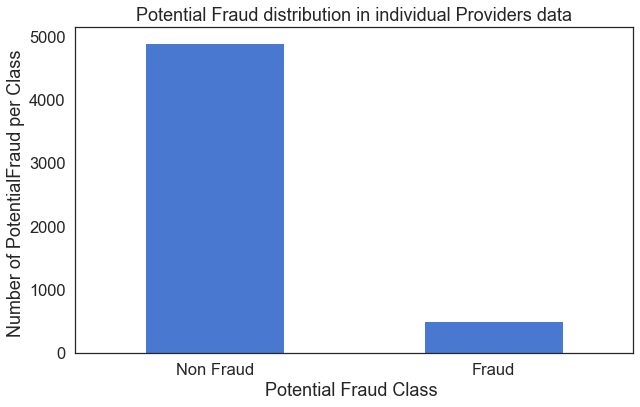

In [36]:
#PLotting the frequencies of fraud and non-fraud transactions in the train data

count_classes_provider = pd.value_counts(Train['PotentialFraud'], sort = True)
print("Percent Distribution of Potential Fraud class:- \n",count_classes_provider*100/len(Train))
LABELS = ["Non Fraud", "Fraud"]
#Drawing a barplot
count_classes_provider.plot(kind = 'bar', rot=0,figsize=(10,6))

#Giving titles and labels to the plot
plt.title("Potential Fraud distribution in individual Providers data")
plt.xticks(range(2), LABELS)
plt.xlabel("Potential Fraud Class ")
plt.ylabel("Number of PotentialFraud per Class ")


plt.savefig('PotentialFraudDistributionImbalance')

In [37]:
print('Providers NonFraud|Fraud Class Percent Distribution in Whole dataset :\n',count_classes/len(Train_ProviderWithPatientDetailsdata)*100)

Providers NonFraud|Fraud Class Percent Distribution in Whole dataset :
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


In [38]:
print('Providers NonFraud|Fraud Class Percent Distribution :\n',count_classes_provider/len(Train)*100)

Providers NonFraud|Fraud Class Percent Distribution :
 No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64


State - wise Percent Beneficiary Distribution

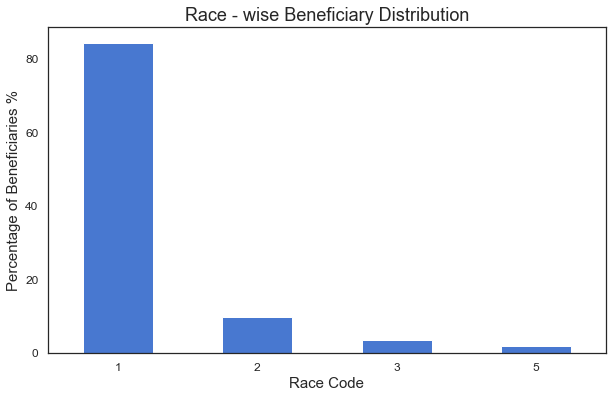

<Figure size 1008x576 with 0 Axes>

In [42]:
#PLotting the frequencies of race-wise beneficiaries
count_Race = pd.value_counts(Train_Beneficiarydata['Race'], sort = True)

#Drawing a barplot
(count_Race*100/len(Train_Beneficiarydata)).plot(kind = 'bar', rot=0,figsize=(10,6),fontsize=12)

#Giving titles and labels to the plot
plt.yticks(np.arange(0,100,20))#, ('0 %','20 %', '40 %', '60 %', '80 %', '100%'))
plt.title("Race - wise Beneficiary Distribution",fontsize=18)
plt.xlabel("Race Code",fontsize=15)
plt.ylabel("Percentage of Beneficiaries "'%',fontsize=15)

plt.show()

plt.savefig('RacewiseBeneficiaryDistribution')

It seems that more than 80% beneficiaries are of same race which is Race 1 which means Maximum population in the dataset originated from same race.There is no race 4 in the dataset

Top-10 Procedures invloved in Healthcare Fraud

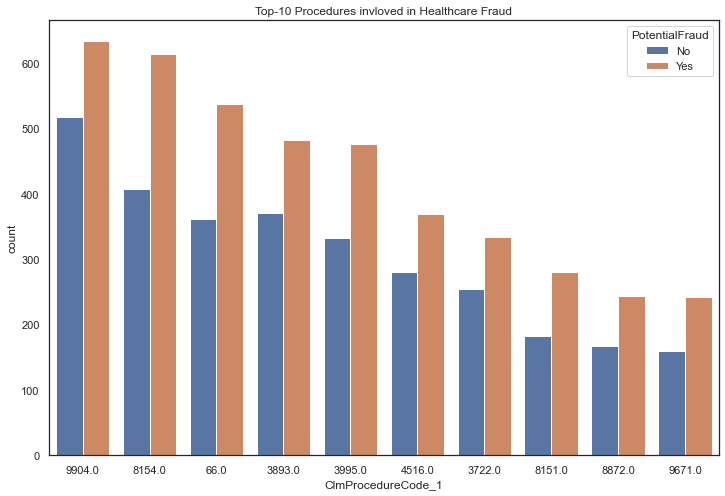

<Figure size 864x576 with 0 Axes>

In [43]:
## Lets plot countplot for each fraud non fraud categories

sns.set(rc={'figure.figsize':(12,8)},style='white')

ax=sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=Train_ProviderWithPatientDetailsdata
              ,order=Train_ProviderWithPatientDetailsdata.ClmProcedureCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Procedures invloved in Healthcare Fraud')
    
plt.show()

plt.savefig('TopProceduresinvlovedinHealthcareFraud')

From the above plot,we can say that Procedure 9904,8154,66 are top procedures (in terms of money involved).Distribution of fraud and non fraud count shows suspicious transactions involved in them.

Top-10 Diagnosis invloved in Healthcare Fraud

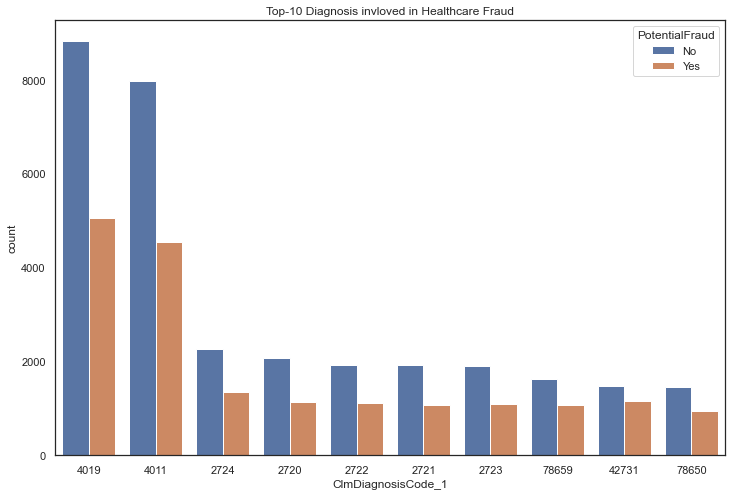

<Figure size 864x576 with 0 Axes>

In [44]:
## lets plot Top-10 Claim Diagnosis  invloved in Healthcare Fraud

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=Train_ProviderWithPatientDetailsdata
              ,order=Train_ProviderWithPatientDetailsdata.ClmDiagnosisCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Diagnosis invloved in Healthcare Fraud')
plt.show()

plt.savefig('TopDiagnosisInnvlovedinHealthcareFraud')

From the above plot,we can say that diagnosis 4019,4011,2724 are top diagnosis (in terms of money involved).Distribution of fraud and non fraud counts shows suspicious transactions involved in them.

Top-20 Attending Physicians invloved in Healthcare Fraud

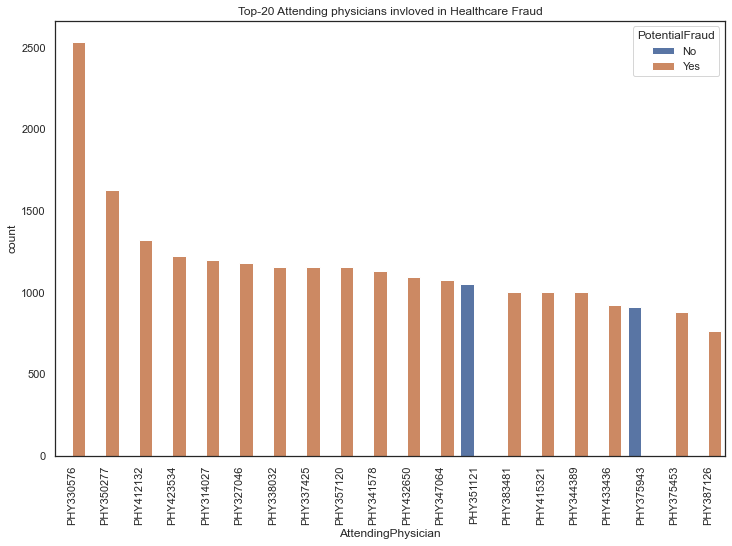

<Figure size 864x576 with 0 Axes>

In [46]:
### lets plot Top-20 Attending Physicians invloved in Healthcare Fraud 

sns.set(rc={'figure.figsize':(12,8)},style='white')

ax= sns.countplot(x='AttendingPhysician',hue='PotentialFraud',data=Train_ProviderWithPatientDetailsdata
              ,order=Train_ProviderWithPatientDetailsdata.AttendingPhysician.value_counts().iloc[:20].index)

    
plt.title('Top-20 Attending physicians invloved in Healthcare Fraud')
plt.xticks(rotation=90)
plt.show()

plt.savefig('TopAttendingphysiciansinvlovedinHealthcareFraud')

In the above plot,we see count of involvement of attending physicians.And flags the nature of provider where they are working is whether fraud or non fraud.

IPAnnualDeductibleAmt Vs IPAnnualReimbursementAmt Fraud and non Fraud Categories

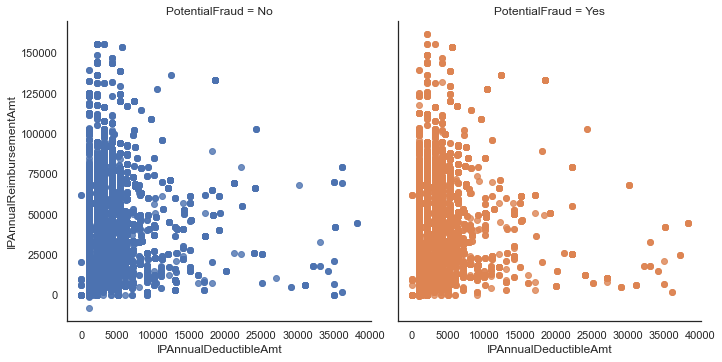

In [47]:
## Lets Plot IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.lmplot(x='IPAnnualDeductibleAmt',y='IPAnnualReimbursementAmt',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_ProviderWithPatientDetailsdata)


#plt.title('IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories')

plt.savefig('IPAnnualDeductibleAmtandIPAnnualReimbursementAmtinbothfraudandnonFraud')

As we see in the above graph,there is no visible difference in IpAnnualDeductibleAmt and IPAnnualReimbursementAmt.

DeductibleAmtPaid Vs InsClaimAmtReimbursed in Fraud and non Fraud Categories

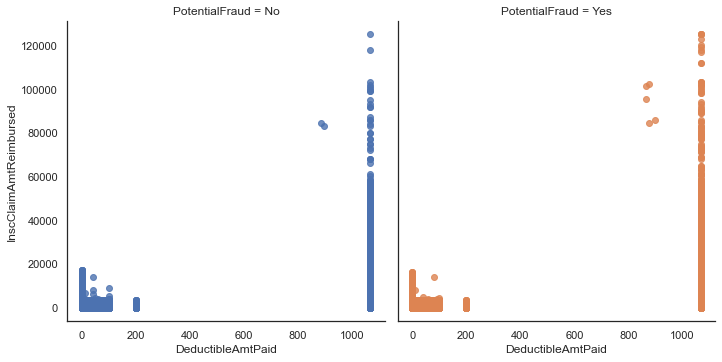

In [48]:
## Lets Plot DeductibleAmtPaid and InsClaimAmtReimbursed in both fraud and non Fraud Categoories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.lmplot(x='DeductibleAmtPaid',y='InscClaimAmtReimbursed',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_ProviderWithPatientDetailsdata)


plt.savefig('DeductibleAmtPaidandInsClaimAmtReimbursed')

We can not differentiate between fraud and non fraud cases based only on DeductibleAmtPaid and InscClaimAmtReimbursed.This lets us derive more features from datasets.

Insurance Claim Amount Reimbursed Vs Age in Fraud and Non Fraud

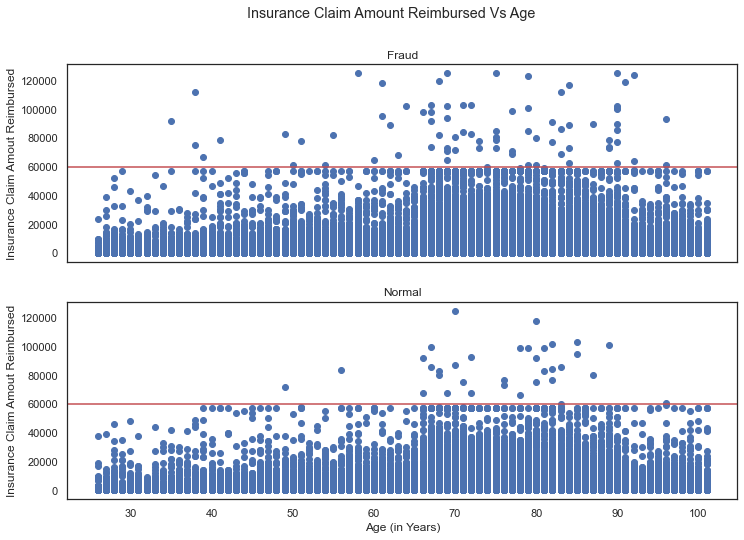

In [49]:
## Let's See Insurance Claim Amount Reimbursed Vs Age
sns.set(rc={'figure.figsize':(12,8)},style='white')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Insurance Claim Amount Reimbursed Vs Age')

ax1.scatter(Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='Yes'].Age, 
            Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='Yes'].InscClaimAmtReimbursed)
ax1.set_title('Fraud')
ax1.axhline(y=60000,c='r')
ax1.set_ylabel('Insurance Claim Amout Reimbursed')

ax2.scatter(Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='No'].Age, 
            Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='No'].InscClaimAmtReimbursed)
ax2.set_title('Normal')
ax2.axhline(y=60000,c='r')
ax2.set_xlabel('Age (in Years)')
ax2.set_ylabel('Insurance Claim Amout Reimbursed')

plt.show()
f.savefig('AgeVsClaimAmtReimbursed')

From the above graph,we see that occurance of fraud cases is more frequent in lower age groups(30-70 years) compared to higher age groups(70+ years).Age is one of the important feature for differentiating between fraud abd non fraud behaviour.

Feature Engineering Append Train to Test to derive more accurate features.

In [51]:
# Lets check the last record of Test_ProviderWithPatientDetailsdata

Test_ProviderWithPatientDetailsdata.iloc[[135391]]

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
135391,PRV57750,BENE150236,CLM675578,2009-11-10,2009-11-10,200,PHY323525,PHY323525,PHY323525,4788,...,1,0,0,0,0,0,290,1120,67.0,0.0


In [52]:
# Lets check the last record of Train_ProviderWithPatientDetailsdata

Train_ProviderWithPatientDetailsdata.iloc[[558210]]

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
558210,PRV57763,No,BENE158531,CLM701529,2009-11-26,2009-11-26,40,PHY321072,NaN,PHY321072,...,1,0,0,0,0,0,3700,240,58.0,0.0


Appending Train data to Test data will help you get good average scores of new features in Test data,as we see not all levels of variables are present in test data compared to train data.So our approach here will be-to append train data to test data ,derive new average features and take only test data to evaluate results.

In [53]:
## Lets create a copy of test data first and merge test with train to get better feature averages

Test_ProviderWithPatientDetailsdata_copy=Test_ProviderWithPatientDetailsdata

In [54]:
#Lets Check shape of copy

print('Shape of Test Copy :-',Test_ProviderWithPatientDetailsdata_copy.shape)

Shape of Test Copy :- (135392, 57)


In [55]:
### We will concat two datasets using columns of Test data only as we dont see target column in Test data.

col_merge=Test_ProviderWithPatientDetailsdata.columns

In [56]:
## Lets add both test and train datasets

Test_ProviderWithPatientDetailsdata=pd.concat([Test_ProviderWithPatientDetailsdata,
                                               Train_ProviderWithPatientDetailsdata[col_merge]])

In [57]:
### Lets verify shape after concatenating

print("Shape of Test After Concatenation",Test_ProviderWithPatientDetailsdata.shape)

print("Expected rows after addition",135392+558211)

Shape of Test After Concatenation (693603, 57)
Expected rows after addition 693603


In [58]:
### Lets check record number 135392 as this will be record from train datasets.
Test_ProviderWithPatientDetailsdata.iloc[[135392]]

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,PRV51001,BENE11727,CLM733300,2009-12-17,2009-12-17,20,PHY383007,NaN,PHY383007,5953,...,1,0,0,0,0,0,300,110,80.0,0.0


In [59]:
##Lets check record number 135392 as this will be record from train datasets.
Test_ProviderWithPatientDetailsdata.iloc[[135392]]

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,PRV51001,BENE11727,CLM733300,2009-12-17,2009-12-17,20,PHY383007,NaN,PHY383007,5953,...,1,0,0,0,0,0,300,110,80.0,0.0


Average Features based on grouping variables. Average features grouped by Provider

In [60]:
Train_ProviderWithPatientDetailsdata["PerProviderAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_Age"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['Age'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartACov"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartBCov"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['AdmitForDays'].transform('mean')

In [61]:
Test_ProviderWithPatientDetailsdata["PerProviderAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_Age"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['Age'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartACov"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartBCov"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['AdmitForDays'].transform('mean')

In [62]:
#lets check shape

print('Train',Train_ProviderWithPatientDetailsdata.shape)
Train_ProviderWithPatientDetailsdata.iloc[:,-10:].head(2)

print("Test ",Test_ProviderWithPatientDetailsdata.shape)
Test_ProviderWithPatientDetailsdata.iloc[:,-10:].head(4)

Train (558211, 68)
Test  (693603, 67)


,PerProviderAvg_InscClaimAmtReimbursed,PerProviderAvg_DeductibleAmtPaid,PerProviderAvg_IPAnnualReimbursementAmt,PerProviderAvg_IPAnnualDeductibleAmt,PerProviderAvg_OPAnnualReimbursementAmt,PerProviderAvg_OPAnnualDeductibleAmt,PerProviderAvg_Age,PerProviderAvg_NoOfMonths_PartACov,PerProviderAvg_NoOfMonths_PartBCov,PerProviderAvg_AdmitForDays
0,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN
1,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN
2,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN
3,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN


Average features grouped by BeneID

In [63]:
## Grouping based on BeneID explains amounts involved per beneficiary.Reason to derive this feature is that one beneficiary 
## can go to multiple providers and can be involved in fraud cases
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['AdmitForDays'].transform('mean')

In [64]:
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['AdmitForDays'].transform('mean')

Average features grouped by OtherPhysician

In [65]:
### Average features grouped by OtherPhysician.

Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['AdmitForDays'].transform('mean')

In [66]:
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['AdmitForDays'].transform('mean')

Average features grouped by OperatingPhysician

In [67]:
##Average features grouped by OperatingPhysician

Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

In [68]:
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

Average features grouped by AttendingPhysician

In [69]:
### Average features grouped by AttendingPhysician   

Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['AdmitForDays'].transform('mean')


In [70]:
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['AdmitForDays'].transform('mean')

Average features grouped by DiagnosisGroupCode

In [71]:
###  Average features grouped by DiagnosisGroupCode  

Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

In [72]:
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

Average features grouped by ClmAdmitDiagnosisCode

In [73]:
### Average features grouped by ClmAdmitDiagnosisCode 

Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')


In [74]:
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')

Average features grouped by ClmProcedureCode_1

In [75]:
### Average features grouped by ClmProcedureCode_1 

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')

In [76]:
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')

Average features grouped by ClmProcedureCode_2

In [77]:
### Average features grouped by ClmProcedureCode_2

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')


In [78]:

Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')

Average features grouped by ClmProcedureCode_3

In [80]:
###  Average features grouped by ClmProcedureCode_3

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')

In [81]:
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_1

In [82]:
### Average features grouped by ClmDiagnosisCode_1 

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')

In [83]:
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_2

In [84]:
###  Average features grouped by ClmDiagnosisCode_2

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')

In [85]:
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_3

In [86]:
###  Average features grouped by ClmDiagnosisCode_3

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')

In [87]:
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_4

In [89]:
###  Average features grouped by ClmDiagnosisCode_4

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')

In [90]:
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')

Claims are filed by Provider,so fraud can be organized crime.So we will check ClmCounts filed by Providers and when pairs like Provider +BeneID, Provider+Attending Physician, Provider+ClmAdmitDiagnosisCode, Provider+ClmProcedureCode_1,Provider+ClmDiagnosisCode_1 are together.

Average Feature based on grouping based on combinations of different variables.

In [91]:
### Average Feature based on grouping based on combinations of different variables

Train_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_OperatingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmAdmitDiagnosisCode"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_2"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_3"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_4"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_5"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_2"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_3"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_4"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_5"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_DiagnosisGroupCode"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OtherPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OperatingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')

Test_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OperatingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmAdmitDiagnosisCode"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_2"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_3"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_4"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_5"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_2"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_3"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_4"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_5"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_DiagnosisGroupCode"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OperatingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')

## Lets Check Shape after creating new features.

print('Train_ProviderWithPatientDetailsdata shape-',Train_ProviderWithPatientDetailsdata.shape)
print('Test_ProviderWithPatientDetailsdata shape-',Test_ProviderWithPatientDetailsdata.shape)

Train_ProviderWithPatientDetailsdata shape- (558211, 188)
Test_ProviderWithPatientDetailsdata shape- (693603, 187)


In [92]:
    ## Lets Check unique values of ICD Diagnosis Codes

diagnosiscode_2chars=Train_ProviderWithPatientDetailsdata['ClmDiagnosisCode_1'].astype(str).str[0:2]

diagnosiscode_2chars.unique()

array(['59', '78', 'V4', '29', '03', '51', 'na', '71', 'V1', '27', '42',
       'V7', '24', '41', '56', '79', '04', '35', '85', 'V5', '72', '44',
       '45', '18', '60', '50', '57', '40', '16', '25', '68', '15', '82',
       '28', '61', '47', '99', '20', '70', '33', '31', '49', '88', '48',
       '53', '43', '91', '55', '00', '58', '73', '46', '19', '17', 'V0',
       '34', 'V6', '62', 'V8', '11', '36', '83', 'E8', '02', '32', '52',
       '38', '23', '84', '37', 'V2', '87', '30', '90', '21', '12', '92',
       '39', '63', '69', '64', '81', '89', '95', '80', '22', '07', '06',
       '93', '94', '54', '26', '05', '13', '74', '14', '98', '08', '97',
       '75', '66', 'E9', '09', '96', '10', '77', '86', '65', '67', '01',
       '76'], dtype=object)

In [93]:
x=diagnosiscode_2chars.sort_values(ascending=True)
x.unique()
#x.value_counts()[:10]

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',
       '99', 'E8', 'E9', 'V0', 'V1', 'V2', 'V4', 'V5', 'V6', 'V7', 'V8',
       'na'], dtype=object)

Above Data Shows that if we take only first 2 characters of diagnosis code for the purpose of grouping them ,we might end up creating large sparse matrix ,as each 'code' column will generate 120+ dummy columns.This will increase computational time and loose explicability.

Data Preprocessing

Impute Numeric columns with 0's.

In [94]:
##### Lets impute numeric columns with 0

cols1 = Train_ProviderWithPatientDetailsdata.select_dtypes([np.number]).columns
cols2 = Train_ProviderWithPatientDetailsdata.select_dtypes(exclude = [np.number]).columns

Train_ProviderWithPatientDetailsdata[cols1] = Train_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
Test_ProviderWithPatientDetailsdata[cols1]=Test_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
print('Test_ProviderWithPatientDetailsdata shape:',Test_ProviderWithPatientDetailsdata.shape)

Test_ProviderWithPatientDetailsdata shape: (693603, 187)


##### Feature Selection

In [95]:
# Lets remove unnecessary columns ,as we grouped based on these columns and derived maximum infromation from them.

cols=Train_ProviderWithPatientDetailsdata.columns
cols[:58]

remove_these_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD',
        'State', 'County']

Train_category_removed=Train_ProviderWithPatientDetailsdata.drop(axis=1,columns=remove_these_columns)
Test_category_removed=Test_ProviderWithPatientDetailsdata.drop(axis=1,columns=remove_these_columns)

In [96]:
## Lets Check shape and missing values

print('Train Shape :',Train_category_removed.shape)
print('Test Shape : ',Test_category_removed.shape)
print("Train Missing Values",Train_category_removed.isnull().sum().sum())
print("Test Missing Values",Test_category_removed.isnull().sum().sum())

Train Shape : (558211, 157)
Test Shape :  (693603, 156)
Train Missing Values 0
Test Missing Values 0


Type Conversion

In [97]:
## Lets Convert types of gender and race to categorical.

Train_category_removed.Gender=Train_category_removed.Gender.astype('category')
Test_category_removed.Gender=Test_category_removed.Gender.astype('category')

Train_category_removed.Race=Train_category_removed.Race.astype('category')
Test_category_removed.Race=Test_category_removed.Race.astype('category')

Dummification

In [98]:
# Lets create dummies for categorrical columns.

Train_category_removed=pd.get_dummies(Train_category_removed,columns=['Gender','Race'],drop_first=True)
Test_category_removed=pd.get_dummies(Test_category_removed,columns=['Gender','Race'],drop_first=True)

In [99]:
Train_category_removed.head().T
Test_category_removed.iloc[135391:135393]

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
135391,PRV57750,200,0.0,0.0,0,12,12,0,1,0,...,0.0,1.0,1.0,0.0,1.0,0.0,1,0,1,0
0,PRV51001,20,0.0,0.0,1,12,12,1,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0


Convert Target values to 1 and 0,wher '1' means Yes and '0' means No

In [100]:
Train_category_removed.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
Train_category_removed.head()
Train_category_removed.PotentialFraud=Train_category_removed.PotentialFraud.astype('int64')
Train_category_removed.PotentialFraud.dtypes
Train_category_removed.PotentialFraud.min()

0

In [101]:
Train_category_removed.PotentialFraud.max()

1

Select only Test related data from merged data

In [102]:
print('Test Shape before removing',Test_category_removed.shape)

Test Shape before removing (693603, 158)


In [103]:
Test_category_removed=Test_category_removed.iloc[:135392]   ##Remove train data from appended test data

In [104]:
Test_category_removed.tail()   # Check last 5 records.

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
135387,PRV57750,1300,0.0,0.0,0,12,12,0,1,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0
135388,PRV57750,10,0.0,0.0,0,12,12,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0
135389,PRV57750,200,0.0,0.0,0,12,12,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0,0
135390,PRV57750,2300,0.0,0.0,0,12,12,1,0,1,...,0.0,1.0,1.0,0.0,1.0,0.0,1,0,0,0
135391,PRV57750,200,0.0,0.0,0,12,12,0,1,0,...,0.0,1.0,1.0,0.0,1.0,0.0,1,0,1,0


In [105]:
print('Test Shape before removing',Test_category_removed.shape)

Test Shape before removing (135392, 158)


Data Aggregation to the Providers level

In [107]:
### Lets aggregate claims data to unique providers.

Train_category_removed_groupedbyProv_PF=Train_category_removed.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
Test_category_removed_groupedbyProv_PF=Test_category_removed.groupby(['Provider'],as_index=False).agg('sum')

In [108]:
print('Providers in Train:' ,Train_category_removed_groupedbyProv_PF.shape)
print('Providers in Test :',Test_category_removed_groupedbyProv_PF.shape)

Providers in Train: (5410, 158)
Providers in Test : (1353, 157)


In [109]:
Train_category_removed_groupedbyProv_PF.head(3)
Test_category_removed_groupedbyProv_PF.head(3)

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51002,53790,380.0,0.0,2424,2460,79,108,72,25,...,0.0,202.0,30.0,0.0,204.0,0.0,134.0,30.0,2.0,4.0
1,PRV51006,30720,0.0,0.0,1224,1224,35,69,50,15,...,0.0,99.0,26.0,0.0,99.0,0.0,59.0,26.0,0.0,0.0
2,PRV51009,27230,1238.0,8.0,468,468,8,17,19,1,...,2.0,40.0,24.0,2.0,41.0,2.0,23.0,6.0,0.0,0.0


Train Validation split

In [110]:
print('Train shape:',Train_category_removed_groupedbyProv_PF.shape)

Train shape: (5410, 158)


In [111]:
Train_category_removed_groupedbyProv_PF.head(3)

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,30.0,300,300,15,19,17,...,2.0,24.0,5.0,2.0,24.0,2.0,16.0,4.0,0.0,0.0
1,PRV51003,1,605670,66286.0,382.0,1560,1567,56,80,64,...,39.0,132.0,45.0,39.0,132.0,39.0,78.0,24.0,0.0,1.0
2,PRV51004,0,52170,310.0,0.0,1768,1782,64,88,50,...,0.0,143.0,27.0,0.0,143.0,0.0,103.0,24.0,5.0,0.0


In [112]:
## Lets Seperate out Target and providers from independent variables.Create Target column y.

X=Train_category_removed_groupedbyProv_PF.drop(axis=1,columns=['Provider','PotentialFraud'])
y=Train_category_removed_groupedbyProv_PF['PotentialFraud']

Standardization

In [113]:
## Lets apply StandardScaler and transform values to its z form,where 99.7% values range between -3 to 3.
sc=StandardScaler()   # MinMaxScaler
sc.fit(X)
X_std=sc.transform(X)

X_teststd=sc.transform(Test_category_removed_groupedbyProv_PF.iloc[:,1:])   #Apply Standard Scaler to unseen data as well.

#print(X_std[0:3,:])
#print(X_teststd[0:3,:])

In [114]:
print('X Shape:',X_std.shape)

X Shape: (5410, 156)


Lets Split data in train and validation

In [115]:
## 'stratify=y' will make sure equal distribution of yes:no in both train and validation

X_train,X_val,y_train,y_val = train_test_split(X_std,y,test_size=0.3,random_state=101,stratify=y,shuffle=True)

In [116]:
print('X_train :',X_train.shape)
print('y_train :',y_train.shape)

print('X_val :',X_val.shape)
print('y_val :',y_val.shape)

X_train : (3787, 156)
y_train : (3787,)
X_val : (1623, 156)
y_val : (1623,)


In [117]:
print('X_teststd',X_teststd.shape)

X_teststd (1353, 156)


##### Model Building
##### Logistic regression

In [118]:
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv=10,class_weight='balanced',random_state=123)    

# The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
#in the input data as ``n_samples / (n_classes * np.bincount(y))``.

log.fit(X_train,y_train)

LogisticRegressionCV(class_weight='balanced', cv=10, random_state=123)

In [119]:
## Lets predict probability of 1 and 0 for X_train and X_val

log_train_pred_probability=log.predict_proba(X_train)
log_val_pred_probability=log.predict_proba(X_val)

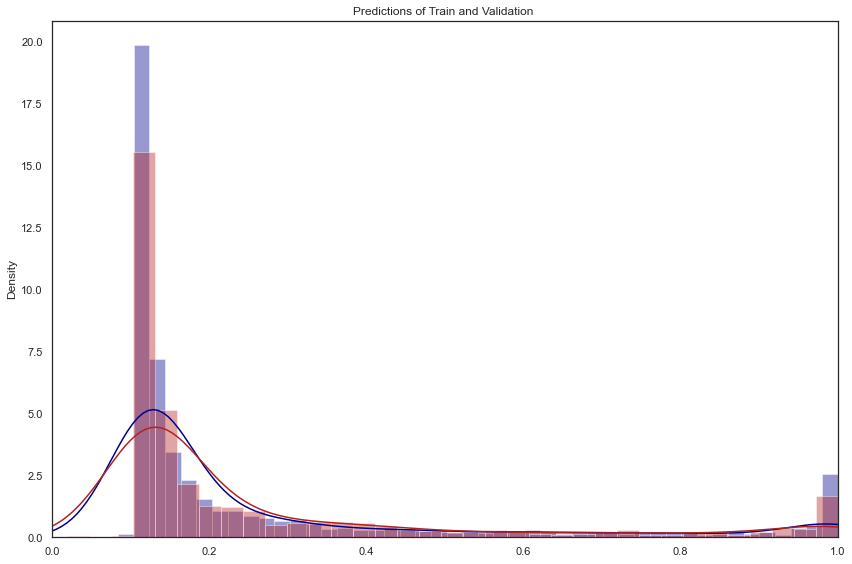

In [120]:
#Logistic Regression Model Prediction for Train and Validation
# Lets compare model prediction performance on train and Validation both.

fig = plt.figure(figsize=(12,8))

sns.distplot(log.predict_proba(X_train)[:,1],color='darkblue')
sns.distplot(log.predict_proba(X_val)[:,1],color='firebrick')
plt.title('Predictions of Train and Validation ')
plt.xlim([0, 1])

plt.tight_layout()

plt.show()

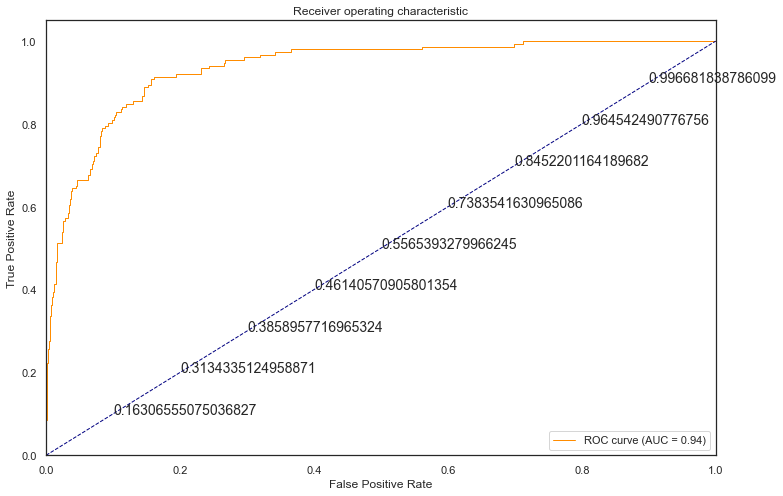

In [121]:
#Logistic regression : ROC Curve
from sklearn.metrics import roc_curve, auc,precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_val,log.predict_proba(X_val)[:,1])         #log_val_pred_probability[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [122]:
fpr, tpr, thresholds =roc_curve(y_val, log.predict_proba(X_val)[:,1],pos_label=1)     #log_val_pred_probability[:,1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.935794


Text(0.5, 1.0, 'Precision Vs Recall')

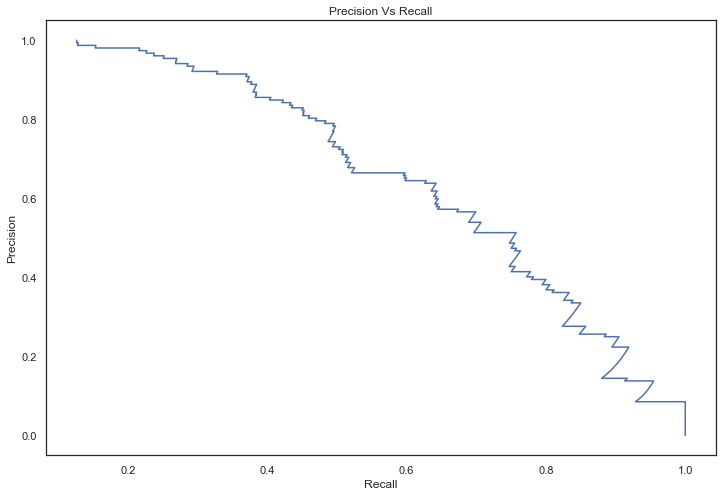

In [123]:
#Logistic Regression : Precision Vs Recall Curve
## Lets Check precision and recall 
precision, recall, _ = precision_recall_curve(y_val, log.predict_proba(X_val)[:,1])

plt.plot(precision,recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Vs Recall')

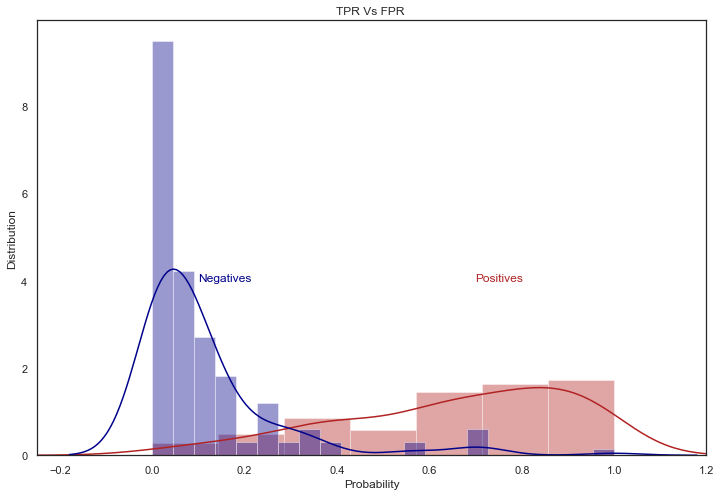

In [124]:
#Logistic Regression : TPR Vs FPR
## Lets Check Tpr vs fpr distribution.

fig = plt.figure(figsize=(12,8))

sns.distplot(tpr,color='firebrick')

sns.distplot(fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

Probability Thresholding

**Thresholding Probabilities:

If the algorithm returns probabilities (or some other score), thresholding can be applied after a model has been built. Essentially you change the classification threshold from 50-50 to an appropriate trade-off level. This typically can be optimized by generated a curve of the evaluation metric (e.g. F-measure). The limitation here is that you are making absolute trade-offs. Any modification in the cutoff will in turn decrease the accuracy of predicting the other class.



In [125]:
## Lets Set probability Threshold to 0.60

log_train_pred_60=(log.predict_proba(X_train)[:,1]>0.60).astype(bool)
log_val_pred_60=(log.predict_proba(X_val)[:,1]>0.60).astype(bool)   # set threshold as 0.60

In [126]:
#Logistic Regression : Evaluation
#Confusion matrix, Accuracy, sensitivity and specificity

from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,auc

cm0 = confusion_matrix(y_train, log_train_pred_60,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, log_val_pred_60,labels=[1,0])
print('Confusion Matrix Val: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train: ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Val: ', accuracy1)

sensitivity0 = cm0[0,0]/(cm0[0,0]+cm0[0,1])
print('Sensitivity Train : ', sensitivity0 )

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity Val: ', sensitivity1 )


specificity0 = cm0[1,1]/(cm0[1,0]+cm0[1,1])
print('Specificity Train: ', specificity0)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity Val: ', specificity1)

KappaValue=cohen_kappa_score(y_val, log_val_pred_60)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, log_val_pred_60)

print("AUC         :",AUC)

print("F1-Score Train  : ",f1_score(y_train, log_train_pred_60))

print("F1-Score Val  : ",f1_score(y_val, log_val_pred_60))

Confusion Matrix Train : 
 [[ 270   84]
 [ 210 3223]]
Confusion Matrix Val: 
 [[ 103   49]
 [  93 1378]]
Accuracy Train:  0.922365988909427
Accuracy Val:  0.9125077017868145
Sensitivity Train :  0.7627118644067796
Sensitivity Val:  0.6776315789473685
Specificity Train:  0.9388290125254879
Specificity Val:  0.9367777022433719
Kappa Value : 0.5438304105142315
AUC         : 0.8072046405953702
F1-Score Train  :  0.6474820143884892
F1-Score Val  :  0.5919540229885056


**Confusion Matrix Confusion Matrix Train : [[ 270 84] [ 210 3223]] Confusion Matrix Val: [[ 103 49] [ 93 1378]] Accuracy Train: 0.922365988909427 Accuracy Val: 0.9125077017868145 Sensitivity Train : 0.7627118644067796 Sensitivity Val: 0.6776315789473685 Specificity Train: 0.9388290125254879 Specificity Val: 0.9367777022433719 Kappa Value : 0.5438304105142315 AUC : 0.8072046405953702 F1-Score Train : 0.6474820143884892 F1-Score Val : 0.5919540229885056**

In [127]:
## Lets predict on Test data

log_test_pred_60 = (log.predict_proba(X_teststd)[:,1]>0.60).astype(bool)
log_test_pred=pd.DataFrame(log_test_pred_60)
log_test_pred.head(2)

,0
0,False
1,False


In [128]:
# Lets Replace 1 with Yes and 0 With No
Replacement = {1:'Yes',0:'No'}

Labels=log_test_pred[0].apply(lambda x : Replacement[x])
Labels.value_counts()    #Check count of Predictions

No     1182
Yes     171
Name: 0, dtype: int64

In [129]:
## Submission file

submission_log=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_log['PotentialFraud']=Labels
submission_log.shape

(1353, 2)

In [130]:
print('Submission Shape:',submission_log.shape)

Submission Shape: (1353, 2)


In [131]:
submission_log.to_csv("Submission_Logistic_Regression_F1_60_Threshold_60Prcnt.csv",index=False)

In [132]:
submission_log.PotentialFraud.value_counts()

No     1182
Yes     171
Name: PotentialFraud, dtype: int64

##### Random Forest

In [133]:
## Lets Apply Random Forest 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=4)   # We will set max_depth =4
rfc.fit(X_train,y_train)  #fit the model

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       random_state=123)

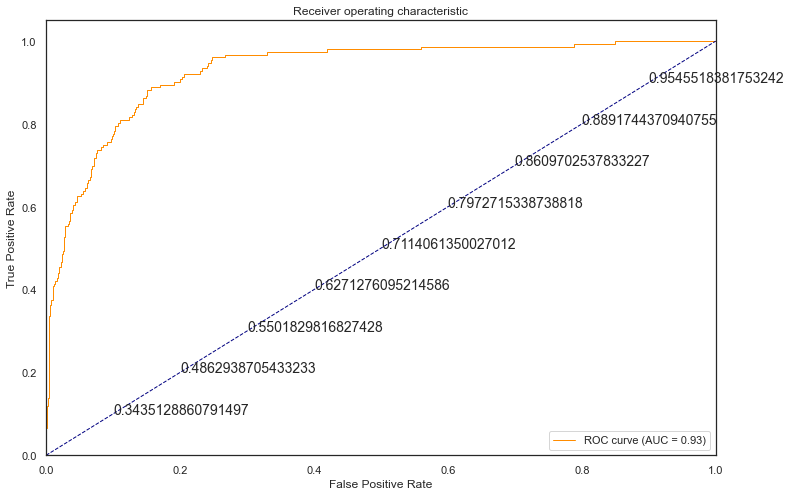

In [134]:
#Random Forest : ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

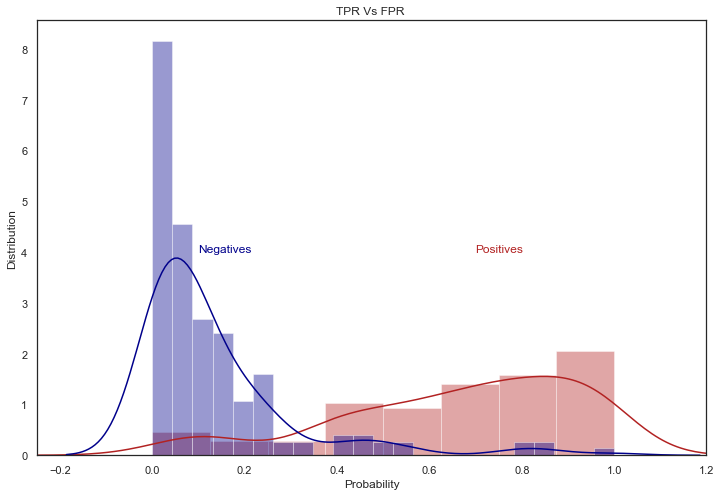

In [135]:
#Random Forest : TPR Vs FPR
fig = plt.figure(figsize=(12,8))

sns.distplot(tpr,color='firebrick')

sns.distplot(fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

In [136]:
rfc_train_pred = (rfc.predict_proba(X_train)[:,1]>0.5).astype(bool)   # Set threshold to 0.5
rfc_val_pred = (rfc.predict_proba(X_val)[:,1]>0.5).astype(bool)# Set threshold to 0.5

In [137]:
#Random Forest : Model Evaluation
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,roc_curve

cm0 = confusion_matrix(y_train, rfc_train_pred,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, rfc_val_pred,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train : ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Test : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

KappaValue=cohen_kappa_score(y_val, rfc_val_pred)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, rfc_val_pred)
print("AUC         :",AUC)


print("F1-Score Train",f1_score(y_train,rfc_train_pred))
print("F1-Score Validation : ",f1_score(y_val, rfc_val_pred))

Confusion Matrix Train : 
 [[ 319   35]
 [ 389 3044]]
Confusion Matrix Test: 
 [[ 124   28]
 [ 182 1289]]
Accuracy Train :  0.8880380248217586
Accuracy Test :  0.8706099815157117
Sensitivity :  0.8157894736842105
Specificity :  0.876274643099932
Kappa Value : 0.47589611108548224
AUC         : 0.8460320583920713
F1-Score Train 0.60075329566855
F1-Score Validation :  0.5414847161572053


Confusion Matrix Train : [[ 275 79] [ 239 3194]] Confusion Matrix Test: [[ 107 45] [ 105 1366]] Accuracy Train : 0.916028518616319 Accuracy Test : 0.9075785582255084 Sensitivity : 0.7039473684210527 Specificity : 0.9286199864038069 Kappa Value : 0.5374522157454344 AUC : 0.8162836774124298 F1-Score Train 0.6336405529953918 F1-Score Validation : 0.587912087912088

Random Forest : Feature Importance

In [138]:
feature_list = list(Test_category_removed_groupedbyProv_PF.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list[1:], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Top -20 features impacting Random forest model and their importance score :- \n',)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:15]];

Top -20 features impacting Random forest model and their importance score :- 

Variable: PerProviderAvg_InscClaimAmtReimbursed Importance: 0.09
Variable: InscClaimAmtReimbursed Importance: 0.07
Variable: PerAttendingPhysicianAvg_InscClaimAmtReimbursed Importance: 0.07
Variable: PerOperatingPhysicianAvg_InscClaimAmtReimbursed Importance: 0.06
Variable: PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed Importance: 0.04
Variable: PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid Importance: 0.04
Variable: PerClmDiagnosisCode_1Avg_DeductibleAmtPaid Importance: 0.04
Variable: PerOperatingPhysicianAvg_IPAnnualReimbursementAmt Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_7 Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_8 Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_9 Importance: 0.03
Variable: DeductibleAmtPaid    Importance: 0.02
Variable: AdmitForDays         Importance: 0.02
Variable: PerProviderAvg_DeductibleAmtPaid Importance: 0.02
Variable: 

In [139]:
#Random Forest : Prediction on Unseen Data
## Lets predict on Test data

rfc_test_pred = rfc.predict(X_teststd)
rfc_test_pred=pd.DataFrame(rfc_test_pred)
rfc_test_pred.head(2)

,0
0,0
1,0


In [140]:
## Lets Replace 1 with Yes and 0 With No

Replacement = {1:'Yes',0:'No'}

Labels=rfc_test_pred[0].apply(lambda x : Replacement[x])

In [141]:
Labels.value_counts()

No     1094
Yes     259
Name: 0, dtype: int64

In [142]:
submission_rfc=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_rfc['PotentialFraud']=Labels
submission_rfc.shape

(1353, 2)

In [143]:
print('Shape Of Submission',submission_rfc.shape)

Shape Of Submission (1353, 2)


In [144]:
    #write Submission file

submission_rfc.to_csv("Submission_Random_Forest_Estimator_F1_60_estimators_3000.csv",index=False)

##### Other Models and their Performance

In [148]:
## Lets import packages 
from collections import Counter
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pprint

In [149]:
clfs = {
    #'mnb': MultinomialNB(),
    'svm1': SVC(C=0.01,kernel='linear',probability=1),
    'svm2': SVC(C=0.01,kernel='rbf',probability=1),
    'svm3': SVC(C=.01,kernel='poly',degree=2,probability=1),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(class_weight='balanced'),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(class_weight='balanced'),
    'xgb': XGBClassifier(booster='gbtree')
}

## Lets Fit These models and check their performance 

f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred =((clf.predict_proba(X_val)[:,1]>0.5).astype(bool))
    f1_scores[clf_name] = f1_score(y_pred, y_val)
    
pprint.pprint(f1_scores) #Printing F1 Scores

svm1
svm2
svm3
ada
dtc
gbc
lr
xgb
{'ada': 0.5309090909090909,
 'dtc': 0.4542372881355932,
 'gbc': 0.596078431372549,
 'lr': 0.6045340050377834,
 'svm1': 0.5,
 'svm2': 0.5573770491803278,
 'svm3': 0.41000000000000003,
 'xgb': 0.48000000000000004}


Above figures shows that Logistic regression model is performing better compared to other models.

Principal Component Analysis

In [150]:
Train_category_removed_groupedbyProv_PF.head(2)
Test_category_removed_groupedbyProv_PF.head(2)

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51002,53790,380.0,0.0,2424,2460,79,108,72,25,...,0.0,202.0,30.0,0.0,204.0,0.0,134.0,30.0,2.0,4.0
1,PRV51006,30720,0.0,0.0,1224,1224,35,69,50,15,...,0.0,99.0,26.0,0.0,99.0,0.0,59.0,26.0,0.0,0.0


In [151]:
# Apply Standard Scaler to scale data
sc_pca=StandardScaler()
sc_pca=sc.fit(Train_category_removed_groupedbyProv_PF.iloc[:,2:])
Train_category_removed_groupedbyProv_PF_scaled=sc_pca.transform(Train_category_removed_groupedbyProv_PF.iloc[:,2:])
Train_category_removed_groupedbyProv_PF_scaled=pd.DataFrame(Train_category_removed_groupedbyProv_PF_scaled)

Test_category_removed_groupedbyProv_PF_scaled=sc_pca.transform(Test_category_removed_groupedbyProv_PF.iloc[:,1:])
Test_category_removed_groupedbyProv_PF_scaled=pd.DataFrame(Test_category_removed_groupedbyProv_PF_scaled)


Test_category_removed_groupedbyProv_PF_scaled.shape

(1353, 156)

In [152]:
Train_category_removed_groupedbyProv_PF_scaled.shape


(5410, 156)

###### PCA : Use maximum Variance

In [153]:
from sklearn.decomposition import PCA  #import PCA
# Lets Take 29 PCA components
pca = PCA(n_components=29)
pca.fit(Train_category_removed_groupedbyProv_PF_scaled.iloc[:,0:])
print('PCA Explained Variance :\n',np.round(pca.explained_variance_ratio_,3))

PCA Explained Variance :
 [0.686 0.218 0.024 0.015 0.009 0.007 0.005 0.004 0.004 0.003 0.003 0.002
 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.    0.    0.    0.    0.   ]


In [154]:
## Transform test and train based on train components
train_pca=pca.transform(Train_category_removed_groupedbyProv_PF_scaled.iloc[:,0:])

test_pca=pca.transform(Test_category_removed_groupedbyProv_PF_scaled)
print('Train Shape:',train_pca.shape)
print('Test Shape:',test_pca.shape)

Train Shape: (5410, 29)
Test Shape: (1353, 29)


In [155]:
## Convert to Pandas dataframe

train_pca=pd.DataFrame((train_pca))
test_pca=pd.DataFrame(test_pca)
print('Train Shape:',train_pca.shape)
print('Test Shape:',test_pca.shape)

Train Shape: (5410, 29)
Test Shape: (1353, 29)


In [156]:
#Add target to train Data
train_pca['PotentialFraud']=Train_category_removed_groupedbyProv_PF.PotentialFraud

train_pca.isnull().sum().sum()
print('Train PCA',train_pca.shape)
#train_pca.head()
print('Test PCA',test_pca.shape)

Train PCA (5410, 30)
Test PCA (1353, 29)


In [157]:
train_pca.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,PotentialFraud
0,-2.392832,-0.339081,0.170838,0.578502,0.199659,0.097188,-0.292168,-0.068517,-0.030015,0.115047,...,-0.089646,-0.039549,-0.017912,-0.104877,-0.171085,0.027990,-0.178723,0.443234,-0.279989,0
1,9.054236,-9.842674,-0.519321,4.510588,-4.187689,-0.024749,0.288515,-0.383274,0.371051,0.307124,...,0.292430,-0.131857,-0.167413,-0.235780,0.138754,0.674504,0.150526,-0.502810,-0.214382,1


Auto - Encoder

**An Autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. Recently, the autoencoder concept has become more widely used for learning generative models of data.

We will use the same technique to learn patterns in non fraud data and we will train the model accordingly.We will use reconstruction error threshold ,to predict the Target class of data.

In [158]:
from sklearn.model_selection import train_test_split
#Converting data to array
train_pca = np.array(train_pca)
test_pca =np.array(test_pca)

In [159]:
#Splitting the data into train and test and observing their dimensions
X_train_pca, X_test_pca = train_test_split(train_pca, test_size=0.2, random_state=123)

print(X_train_pca.shape)
print(X_test_pca.shape)
print(test_pca.shape)

(4328, 30)
(1082, 30)
(1353, 29)


In [160]:
#Obtaining the fraud and non-fraud records in train
print(np.unique(X_train_pca[:,29],return_counts=True))
print(np.unique(X_test_pca[:,29],return_counts=True))

(array([0., 1.]), array([3916,  412], dtype=int64))
(array([0., 1.]), array([988,  94], dtype=int64))


We will consider Non fraud data to train the autoencoder and check the threshold for reconstruction error on fraud data.

In [161]:
#Now consider only the non-fraud records for training
X_train_NF = X_train_pca[X_train_pca[:,-1] == 0]
X_train_NF = X_train_NF[:,:-1]
print(X_train_NF.shape)

(3916, 29)


In [162]:
#Separating out the fraud records from the train 
X_train_F = X_train_pca[X_train_pca[:,-1] == 1]
print(X_train_F.shape)

(412, 30)


In [163]:
#Adding/concatenating the fraud records from train data to the test
X_test_pca=np.concatenate((X_test_pca,X_train_F),axis=0)
print(X_test_pca.shape)

(1494, 30)


In [164]:
X_test,X_eval = train_test_split(X_test_pca, test_size=0.2, random_state=123)

In [165]:
print(X_test.shape)
print(X_eval.shape)

(1195, 30)
(299, 30)


In [166]:
#Separating the independent and the class variable
y_test = X_test[:,-1]
X_test = X_test[:,:-1]

In [167]:
#Expanding the dimensions of y for later concatenation
y_test = np.expand_dims(y_test, axis=1)
y_test.shape

(1195, 1)

Autoencoder Network Building

In [169]:
input_dim = X_train_NF.shape[1]   # Set input dimension to number of inputs
encoding_dim = 15               # set encoding dimension to size 15

In [170]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

autoencoder = Sequential()   # Add sequential network

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))   # Add dropout to add noise to data.
autoencoder.add(Dense(encoding_dim, activation='relu'))   #Add Dense layer to encode patterns. 
autoencoder.add(Dense(input_dim, activation='linear'))    #Add Dense layer of size of input shape

In [171]:
nb_epoch = 100    #number of epochs
batch_size = 32   #batchsize or sample size

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])                      ## We will use mse as a metric as each neuron can be a linear regression model

In [172]:
## Fit the model and save history
hist = []
for _ in range(100):
    hist.append(autoencoder.fit(X_train_NF, X_train_NF,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=0).history)

In [173]:
hist[0:5]   #First 5 records of history

[{'loss': [1.521264672279358],
  'mse': [1.521264672279358],
  'val_loss': [0.952545702457428],
  'val_mse': [0.952545702457428]},
 {'loss': [1.0172383785247803],
  'mse': [1.0172383785247803],
  'val_loss': [0.681331217288971],
  'val_mse': [0.681331217288971]},
 {'loss': [0.7179989218711853],
  'mse': [0.7179989218711853],
  'val_loss': [0.460659921169281],
  'val_mse': [0.460659921169281]},
 {'loss': [0.4809495806694031],
  'mse': [0.4809495806694031],
  'val_loss': [0.3059593141078949],
  'val_mse': [0.3059593141078949]},
 {'loss': [0.3703382611274719],
  'mse': [0.3703382611274719],
  'val_loss': [0.22606733441352844],
  'val_mse': [0.22606733441352844]}]

In [174]:
## Making predictions on the train data
predictions=autoencoder.predict(X_train_NF)
predictions[0:2]   #See the predictions

array([[-3.94867373e+00,  4.64677840e-01,  4.83332932e-01,
         8.61853957e-02,  1.25086546e-01,  7.05575198e-03,
         2.32467368e-01, -4.18159962e-02, -1.29778087e-02,
        -5.37613630e-02, -3.78681496e-02,  2.69164145e-02,
        -6.70212507e-03,  1.13795102e-02,  4.41146716e-02,
         8.66904855e-03, -5.31763695e-02,  2.57914774e-02,
        -5.18477559e-02,  7.29501247e-04, -9.92685556e-03,
        -1.11843944e-02, -3.80309150e-02,  2.12564319e-02,
        -9.54616070e-03,  2.19071209e-02,  1.85737908e-02,
         1.58867240e-02,  2.39384687e-03],
       [-2.46673441e+00, -1.45076585e+00,  8.45987558e-01,
        -1.59979963e+00,  6.59920633e-01, -4.51841325e-01,
        -6.88226521e-02, -9.79720503e-02, -6.39558733e-01,
         1.02962166e-01,  1.76386714e-01, -3.15935314e-01,
         1.51973218e-01, -1.78114399e-01,  1.63495645e-01,
         6.46443516e-02,  1.63297370e-01, -1.53317805e-02,
        -4.63715568e-02, -1.44249767e-01,  6.33933768e-02,
         4.39

In [175]:
##We want to separate out fraud records and non-fraud records for later use
f = np.hstack((X_test,y_test))
print(f.shape)

test_nf=f[f[:,29]==0]
print('Test_nf',test_nf.shape)

test_f=f[f[:,29]==1]
print('Test_f',test_f.shape)

(1195, 30)
Test_nf (788, 30)
Test_f (407, 30)


In [176]:
#Getting the errors from the non fraud data separately 
autoencoder.evaluate(test_nf[:,:29],test_nf[:,:29])

25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - mse: 0.0774


[0.07736127823591232, 0.07736127823591232]

In [177]:
#Getting the errors from the fraud data separately
autoencoder.evaluate(test_f[:,:29],test_f[:,:29])

13/13 [==============================] - 0s 1ms/step - loss: 9.5858 - mse: 9.5858


[9.585813522338867, 9.585813522338867]

In [178]:
#Obtaining predictions for non fraud records
predictions_nf=autoencoder.predict(test_nf[:,:29])

In [179]:
#Obtaining predictions for fraud records
predictions_f=autoencoder.predict(test_f[:,:29])

In [180]:
#Identifying the error computation method by autoencoder(Mean Squared Error). The computation is as follows 
np.mean(np.square(np.abs(test_nf[:,:29]-predictions_nf)))

0.07736128716816201

In [181]:
#Computing errors on the non-fraud data
errors_nf = np.mean(np.square(np.abs(test_nf[:,:29]-predictions_nf)), axis=1)

In [182]:
errors_nf[0:5]

array([0.00162208, 0.00074149, 0.01114249, 0.00163462, 0.00097314])

In [183]:
#Computing errors on the fraud data
errors_f = np.mean(np.square(np.abs(test_f[:,:29]-predictions_f)), axis=1)

In [184]:
errors_f[0:5]

array([ 0.06844387,  0.08585405,  0.14219546,  3.49590259, 18.01216368])

In [185]:
#Computing the distribution of errors in both non-fraud and fraud data
print(np.min(errors_nf))
print(np.max(errors_nf))
print(np.median(errors_nf))

print(np.min(errors_f))
print(np.max(errors_f))
print(np.median(errors_f))

0.0004687403837485075
28.038735448275432
0.0054198504135661695
0.0015637091229865753
716.9262380404735
0.2482902128487265


Text(0.5, 0.98, 'Error boxplot for Fraud and nonfraud')

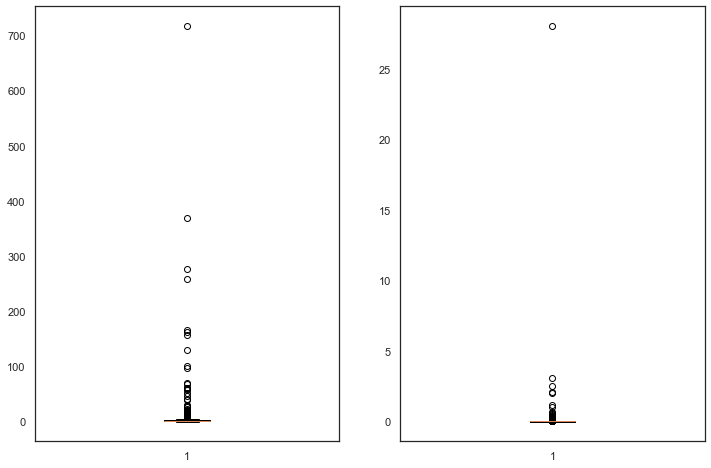

In [186]:
0.24613738200955018
#PLotting the error box plots 

plt.subplot(1, 2,1)
plt.boxplot(errors_f)

plt.subplot(1, 2, 2)
plt.boxplot(errors_nf)

fig.suptitle('Error boxplot for Fraud and nonfraud')

In [187]:
#Experimentation to fix a threshold for classification of a transaction into fraud or non-fraud
print(sum(errors_nf>np.median(errors_f)))
print(sum(errors_f<np.median(errors_f)))
print(sum(errors_f<np.median(errors_nf)))
print(sum(errors_nf>np.median(errors_nf)))

23
203
7
394


In [188]:
print(errors_nf.shape)
print(errors_f.shape)

(788,)
(407,)


In [189]:
print(predictions_nf.shape)
print(predictions_f.shape)

(788, 29)
(407, 29)


In [190]:
test_pred = autoencoder.predict(X_test[:,:29])
test_recon  = (((test_pred-X_test)**2).mean(-1))

train_pred = autoencoder.predict(X_train_NF[:,:29])
mean_recon = (((train_pred - X_train_NF)**2).mean(-1).mean())

from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix

scores_f1 = []
thres = []

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    scores_f1.append(f1_score(y_test,fraud))
    thres.append(th+mean_recon)
    

In [191]:
X_test.shape

(1195, 29)

0.1633178604255896


array([[752,  36],
       [170, 237]], dtype=int64)

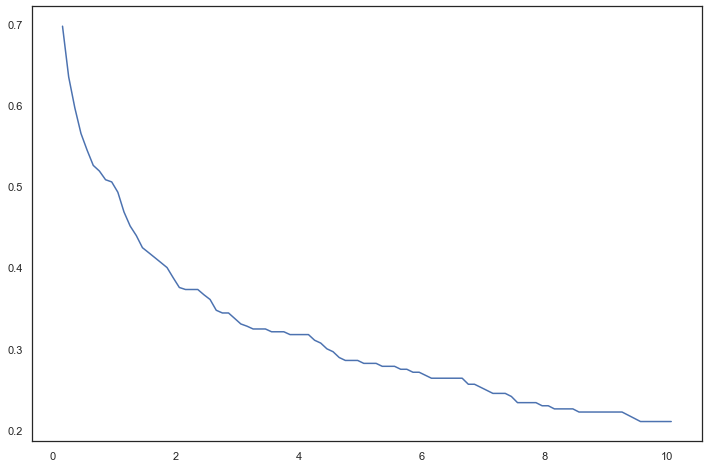

In [192]:
plt.plot(thres, scores_f1)

print(thres[np.array(scores_f1).argmax()])

fraud = (test_recon>thres[np.array(scores_f1).argmax()])

confusion_matrix(y_test, fraud)

In [193]:
##Predicting on Valdation 

predictions_eval=autoencoder.predict(X_eval[:,:29])

In [194]:
errors_eval=np.square(np.subtract(predictions_eval,X_eval[:,:29]))

In [195]:
threshold=0.1718219230420997

fraud_eval=(((errors_eval-X_eval[:,:29])**2).mean(-1))>threshold

In [196]:
print(confusion_matrix(y_true=X_eval[:,29],y_pred=fraud_eval,labels=[1,0]))

[[ 98   1]
 [190  10]]


In [197]:
#Obtaining errors on individual attributes on non-fraud data
ind_errors_nf=np.abs(np.subtract(predictions_nf,test_nf[:,:29]))
print(ind_errors_nf.shape)

(788, 29)


In [198]:
#Obtaining errors on individual attributes on fraud data
ind_errors_f=np.abs(np.subtract(predictions_f,test_f[:,:29]))
print(ind_errors_f.shape)

(407, 29)


In [199]:
#Combining all fraud and non-fraud data errors
X=np.concatenate((ind_errors_f,ind_errors_nf),axis=0)
print(X.shape)

(1195, 29)


In [200]:
#Creating a target column
x=np.array([1,0])
Y=np.repeat(x,[788,407])

In [201]:
#Expanding the shape of the target for merging with all other attributes
print(Y.shape)
Y = np.expand_dims(Y, axis=1)
print(Y.shape)

(1195,)
(1195, 1)


In [202]:
#Concatenating all the attribute errors with target class
X=np.concatenate((X,Y),axis=1)
print(X.shape)

(1195, 30)


In [203]:
map(str,range(X.shape[1]))

In [204]:
#Creating a data frame and naming the columns
X=pd.DataFrame(X)
X.columns = map(str, range(X.shape[1]))

In [205]:
#Melting the data for box plot visualization
M = pd.melt(X, "29", var_name="var", value_name="value")
M['29'].astype('category')
M.tail()
#M.head()

,29,var,value
34650,0.0,28,0.021181
34651,0.0,28,0.312640
34652,0.0,28,0.010621
34653,0.0,28,0.005319
34654,0.0,28,0.084086


In [208]:
pred_nf=ind_errors_nf[:,[0,1,11,17,18,4,8,14]]
np.mean(pred_nf,axis=0)

array([0.30523119, 0.16948842, 0.11195882, 0.13421487, 0.11870382,
       0.08730365, 0.05625037, 0.08809674])

In [209]:
pred_f=ind_errors_f[:,[0,1,11,17,18,4,8,14]]
np.mean(pred_f,axis=0)

array([4.87459168, 3.63403771, 0.60141557, 0.56671093, 0.47180086,
       0.69827424, 0.62207995, 0.52227949])

In [210]:
#Percentile distribution of absolute errors
percentile_nf=np.percentile(ind_errors_nf[:,[0,1,11,17,18,4,8,14]],[10,20,30,40,50,60,70,80,90,100],axis=0)

In [211]:
percentile_nf

array([[4.45927438e-02, 1.69703691e-02, 1.50088051e-02, 8.77605172e-03,
        9.46936212e-03, 5.60690281e-03, 6.02743920e-03, 5.87438030e-03],
       [7.89068762e-02, 3.89117833e-02, 2.49989626e-02, 1.93888348e-02,
        2.03534298e-02, 1.02163021e-02, 1.08123742e-02, 1.15506851e-02],
       [1.10690440e-01, 5.69537969e-02, 3.23540037e-02, 3.31299682e-02,
        2.83620398e-02, 1.49956422e-02, 1.26165855e-02, 1.79413922e-02],
       [1.47955378e-01, 7.66376461e-02, 3.62389482e-02, 4.89949513e-02,
        4.14958796e-02, 1.91670309e-02, 1.51964891e-02, 2.73211720e-02],
       [1.74199547e-01, 9.14138250e-02, 4.51252019e-02, 6.78878956e-02,
        5.86830344e-02, 2.72123896e-02, 2.03536387e-02, 3.69868603e-02],
       [2.04191568e-01, 1.05453902e-01, 6.45518316e-02, 1.01488710e-01,
        8.65405188e-02, 4.17288621e-02, 2.59442849e-02, 5.34256846e-02],
       [2.50351243e-01, 1.33573167e-01, 1.01791686e-01, 1.29809572e-01,
        1.24628000e-01, 6.74126357e-02, 3.57915954e-02, 7.

In [212]:
percentile_nf[:,7]

array([0.00587438, 0.01155069, 0.01794139, 0.02732117, 0.03698686,
       0.05342568, 0.07798281, 0.11929484, 0.21036692, 2.41090289])

In [213]:
percentile_f=np.percentile(ind_errors_f[:,[0,1,11,17,18,4,8,14]],[10,20,30,],axis=0)
np.percentile(ind_errors_f[:,[0,1,11,17,18,4,8,14]],[10,20,30,40,50,60,70,80,90,100],axis=0)

array([[1.15293573e-01, 7.99568595e-02, 4.93534896e-02, 3.81113576e-02,
        3.88393803e-02, 4.30764435e-02, 2.63894736e-02, 3.18958586e-02],
       [2.58392321e-01, 1.82515962e-01, 1.00676796e-01, 7.93339623e-02,
        8.42639933e-02, 9.25680960e-02, 5.46251566e-02, 6.21044493e-02],
       [4.81919674e-01, 2.77524589e-01, 1.61965449e-01, 1.28065915e-01,
        1.26066935e-01, 1.55172799e-01, 9.16684540e-02, 9.34553468e-02],
       [7.66599492e-01, 4.57180165e-01, 2.40074751e-01, 1.91525884e-01,
        1.93847194e-01, 2.28251042e-01, 1.28944778e-01, 1.42559310e-01],
       [1.14815880e+00, 6.79170894e-01, 3.17627310e-01, 2.70915673e-01,
        2.93796884e-01, 3.28249532e-01, 1.94821067e-01, 2.00032286e-01],
       [1.74517601e+00, 1.28952354e+00, 4.16041418e-01, 3.80171751e-01,
        3.87731444e-01, 4.31543998e-01, 2.59750967e-01, 2.53887433e-01],
       [3.16032402e+00, 2.36090557e+00, 5.55914044e-01, 5.11447899e-01,
        5.31351907e-01, 6.64937801e-01, 4.04965669e-01, 3.

In [214]:
percentile_f[:,7]

array([0.03189586, 0.06210445, 0.09345535])

##### Set Threshold

In [215]:
thr= 0.10003411   #0.50795386       #0.32079228

test_pred = autoencoder.predict(X_test)
test_pred.shape

(1195, 29)

In [216]:
recon_error= np.abs(np.subtract(test_pred,X_test[:,:29]))

In [217]:
recon_error.shape

(1195, 29)

In [218]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix
fraud = (recon_error[:,1]>thr)
print("Recall=",recall_score(y_test,fraud))
print("Precision=",precision_score(y_test,fraud))
print("Accuracy=",accuracy_score(y_test,fraud))
print("F1-Score",f1_score(y_test,fraud))

Recall= 0.8796068796068796
Precision= 0.5063649222065064
Accuracy= 0.6669456066945607
F1-Score 0.6427289048473968


In [219]:
print(confusion_matrix(y_true=y_test,y_pred=fraud,labels=[1,0]))

[[358  49]
 [349 439]]


In [220]:
#Evaluation
predictions_eval=autoencoder.predict(X_eval[:,:29])
predictions_eval.shape

(299, 29)

In [221]:
ind_errors_eval=np.abs(np.subtract(predictions_eval,X_eval[:,:29]))
ind_errors_eval.shape

(299, 29)

In [222]:
fraud_eval=ind_errors_eval[:,1]>thr
print("Recall",recall_score(X_eval[:,29],fraud_eval))
print("Precision",precision_score(X_eval[:,29],fraud_eval))
print("Accuracy",accuracy_score(X_eval[:,29],fraud_eval))
print("F1-Score",f1_score(X_eval[:,29],fraud_eval))

Recall 0.898989898989899
Precision 0.5114942528735632
Accuracy 0.6822742474916388
F1-Score 0.652014652014652


In [223]:
print(confusion_matrix(y_true=X_eval[:,29],y_pred=fraud_eval,labels=[1,0]))

[[ 89  10]
 [ 85 115]]


In [224]:
fraud_eval[:6]

array([ True, False,  True, False,  True, False])

###### Let's predict on unseen data

In [225]:
predictions_unseen=autoencoder.predict(test_pca[:,:29])
predictions_unseen.shape

(1353, 29)

In [226]:
ind_errors_unseen=np.abs(np.subtract(predictions_unseen,test_pca[:,:29]))
ind_errors_unseen.shape

(1353, 29)

In [227]:
fraud_unseen=ind_errors_unseen[:,1]>thr

In [228]:
fraud_unseen.shape

(1353,)

In [229]:
fraud_unseen[:5]

array([ True, False,  True, False,  True])

##### Evaluate results with the best performing model

In [230]:
print("Recall",recall_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))
print("Precision",precision_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))
print("Accuracy",accuracy_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))
print("F1-Score",f1_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))

Recall 0.9298245614035088
Precision 0.24766355140186916
Accuracy 0.6341463414634146
F1-Score 0.39114391143911437


In [231]:
fraud_unseen=pd.DataFrame(fraud_unseen)
fraud_unseen.shape
fraud_unseen.head(2)

,0
0,True
1,False


In [232]:
Replacement = {1:'Yes',0:'No'}

AE_Labels=fraud_unseen[0].apply(lambda x : Replacement[x])
AE_Labels.value_counts()

No     711
Yes    642
Name: 0, dtype: int64

In [233]:
submission_AutoEncoder=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_AutoEncoder['PotentialFraud']=AE_Labels
submission_AutoEncoder.head(16)

,Provider,PotentialFraud
0,PRV51002,Yes
1,PRV51006,No
2,PRV51009,Yes
3,PRV51010,No
4,PRV51018,Yes
5,PRV51019,No
6,PRV51020,Yes
7,PRV51022,No
8,PRV51028,No
9,PRV51033,Yes


In [234]:
submission_AutoEncoder.shape

(1353, 2)

In [235]:
#Autoencoder with 2 hidden layers
df = pd.DataFrame(train_pca)  #Again use train 
df.shape

(5410, 30)

In [236]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.392832,-0.339081,0.170838,0.578502,0.199659,0.097188,-0.292168,-0.068517,-0.030015,0.115047,...,-0.089646,-0.039549,-0.017912,-0.104877,-0.171085,0.027990,-0.178723,0.443234,-0.279989,0.0
1,9.054236,-9.842674,-0.519321,4.510588,-4.187689,-0.024749,0.288515,-0.383274,0.371051,0.307124,...,0.292430,-0.131857,-0.167413,-0.235780,0.138754,0.674504,0.150526,-0.502810,-0.214382,1.0
2,-0.011515,2.046151,-0.716978,-0.146993,0.017184,-0.050673,0.091485,0.276244,0.061555,0.071442,...,-0.014082,-0.195703,0.098267,-0.182524,0.007628,-0.089232,0.045578,0.041765,-0.041869,0.0
3,27.556811,15.327474,-6.246961,-1.948628,-1.010868,-0.633404,-0.175226,2.861288,0.735608,2.526891,...,-1.059889,0.654858,0.776903,-0.584943,0.533598,0.020639,-0.302169,0.351979,0.301140,1.0
4,-2.129760,0.780021,-0.077544,0.084201,-0.095472,-0.049679,0.434814,0.030702,-0.006299,0.114903,...,0.039116,-0.130938,-0.033663,-0.046332,-0.025523,-0.159108,0.038686,-0.040089,0.015618,0.0


In [237]:
df.isnull().values.any()   #check null values

False

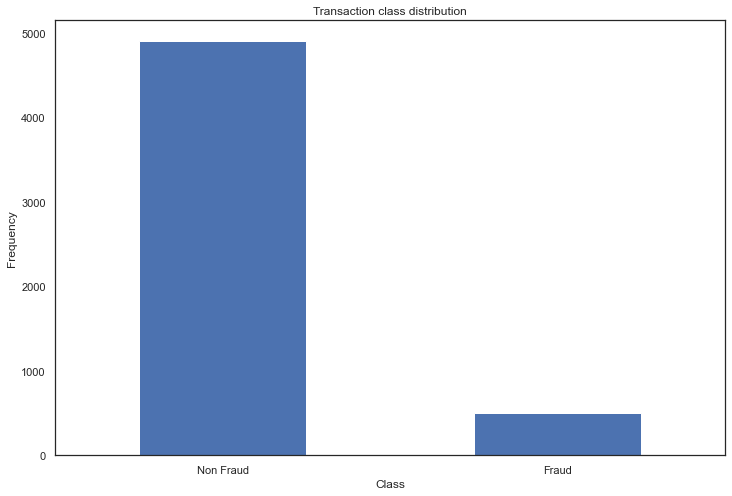

In [238]:
# Lets check distruibution of classes
count_classes = pd.value_counts(df.iloc[:,29], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [239]:
frauds = df[df.iloc[:,29] == 1]
normal = df[df.iloc[:,29] == 0]
print('Fraud data shape:',frauds.shape)

Fraud data shape: (506, 30)


In [240]:
print('Normal data shape:',normal.shape)

Normal data shape: (4904, 30)


In [241]:
X_train_AE, X_test_AE = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train_AE = X_train_AE[X_train_AE.iloc[:,29] == 0]
X_train_AE = X_train_AE.drop([29], axis=1)
y_test_AE = X_test_AE[29]
X_test_AE = X_test_AE.drop([29], axis=1)
X_train_AE = X_train_AE.values
X_test_AE = X_test_AE.values
X_train_AE.shape

###df[ df.columns[[1,3]] ]

(3927, 29)

In [242]:
#Add 2 hidden layers to autoencoder
input_dim = X_train_AE.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',     #Tensorboard 
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train_AE, X_train_AE,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_AE, X_test_AE),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
123/123 [==============================] - 2s 11ms/step - loss: 1.0733 - accuracy: 0.4594 - val_loss: 3.5974 - val_accuracy: 0.5582
Epoch 2/100
123/123 [==============================] - 1s 7ms/step - loss: 0.9957 - accuracy: 0.5368 - val_loss: 3.4293 - val_accuracy: 0.5906
Epoch 3/100
123/123 [==============================] - 1s 7ms/step - loss: 0.9387 - accuracy: 0.7074 - val_loss: 3.3099 - val_accuracy: 0.8244
Epoch 4/100
123/123 [==============================] - 1s 7ms/step - loss: 0.8830 - accuracy: 0.8332 - val_loss: 3.1920 - val_accuracy: 0.8124
Epoch 5/100
123/123 [==============================] - 1s 6ms/step - loss: 0.8409 - accuracy: 0.8330 - val_loss: 3.1112 - val_accuracy: 0.8383
Epoch 6/100
123/123 [==============================] - 1s 5ms/step - loss: 0.8121 - accuracy: 0.8485 - val_loss: 3.0463 - val_accuracy: 0.8512
Epoch 7/100
123/123 [==============================] - 1s 5ms/step - loss: 0.7890 - accuracy: 0.8612 - val_loss: 2.9910 - val_accuracy: 0.837

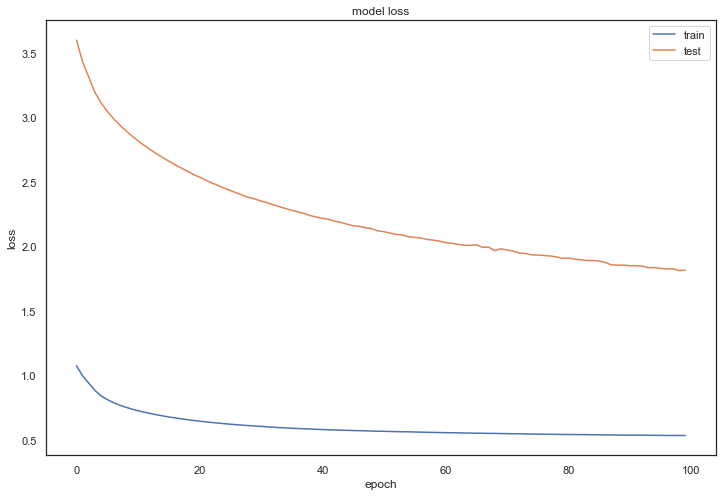

In [243]:
#Lets Load Model
autoencoder = load_model('model.h5')
#plot the loss and Val loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [244]:
## Lets predict on test and evaluate

predictions = autoencoder.predict(X_test_AE)
mse = np.mean(np.power(X_test_AE - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test_AE})
error_df.describe()

,reconstruction_error,true_class
count,1082.000000,1082.000000
mean,1.811622,0.097043
std,12.804340,0.296153
min,0.025581,0.000000
25%,0.259362,0.000000
50%,0.453662,0.000000
75%,0.588374,0.000000
max,272.605128,1.000000


(0.0, 30.0)

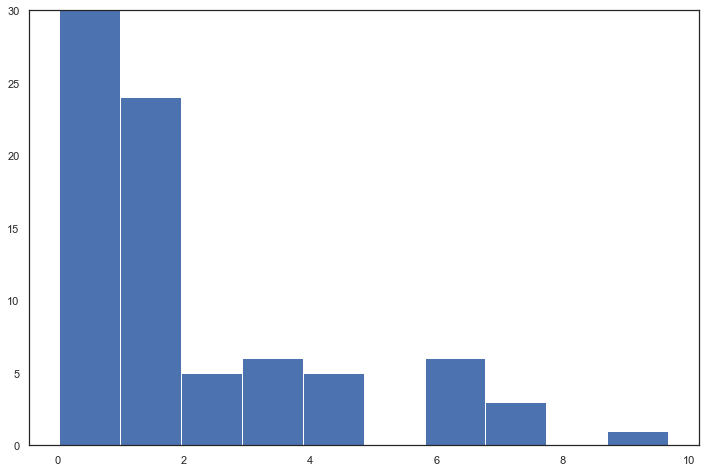

In [245]:
#Reconstruction error for Normal data
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

ax.set_ylim(0,30)

(0.0, 30.0)

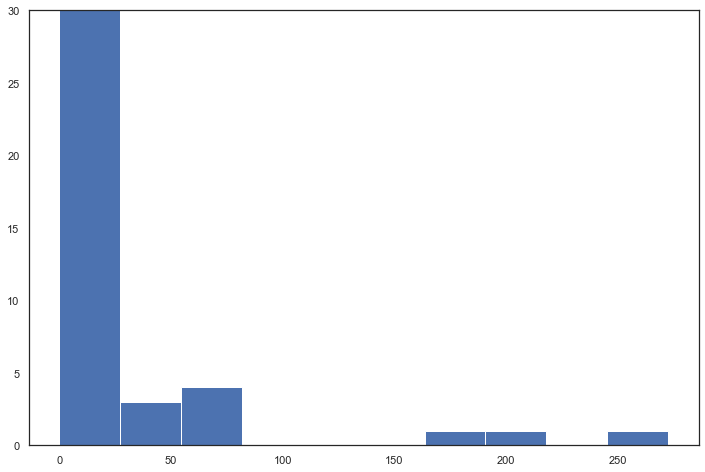

In [246]:
## Reconstruction Error with Fraud data

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
ax.set_ylim(0,30)

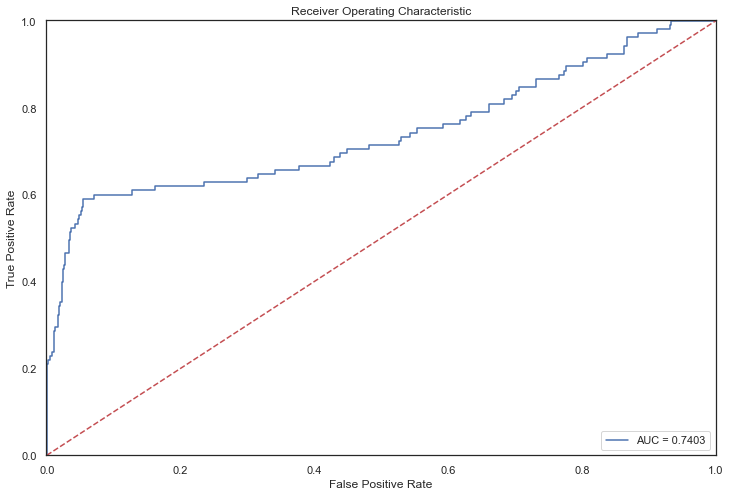

In [247]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
###ROC for errors and true class

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

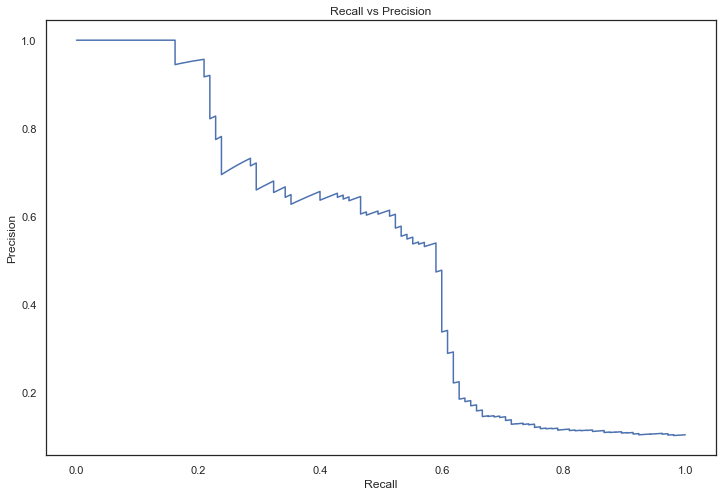

In [248]:
## Recall Vs Precision

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

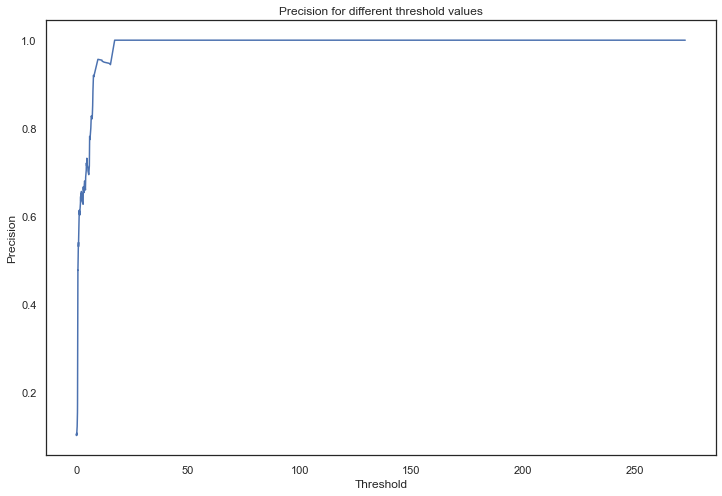

In [249]:
#Threshold Vs Precision 
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

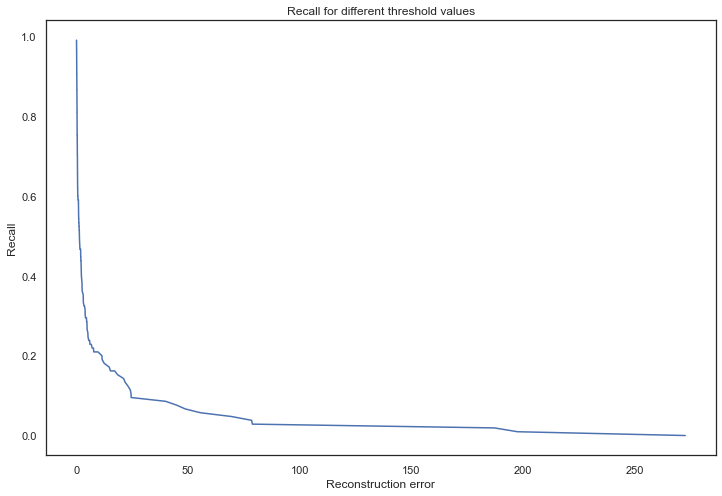

In [250]:
##Recall vs Thresold
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

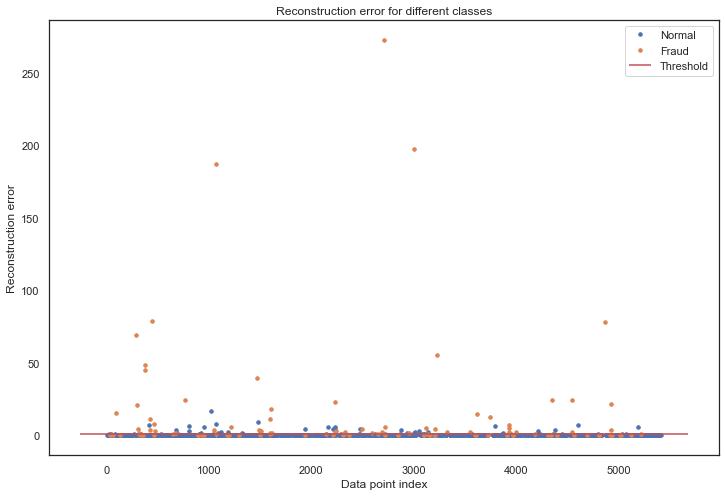

In [251]:
threshold =0.95
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

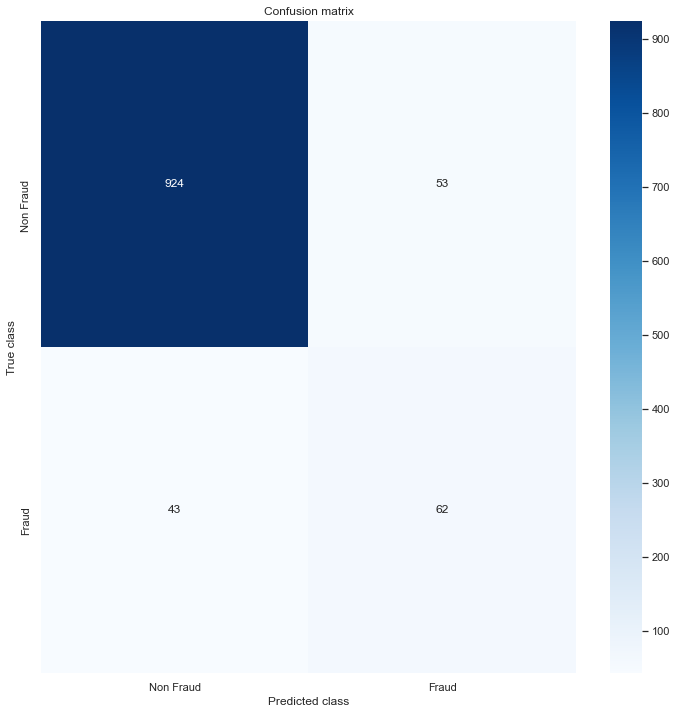

In [252]:
## Predict class based on error threshold

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred,labels=[0,1])
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap='Blues');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [253]:
#print('F1_Score:',f1_score(error_df.true_class, y_pred))
print('F1_Score:',f1_score(error_df.true_class, y_pred))

F1_Score: 0.5636363636363636


In [254]:
cm1 = confusion_matrix(error_df.true_class, y_pred,labels=[1,0])
print('Confusion Matrix Val: \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Val: ', accuracy1)


sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity Val: ', sensitivity1 )


specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity Val: ', specificity1)

KappaValue=cohen_kappa_score(error_df.true_class, y_pred)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(error_df.true_class, y_pred)

print("AUC         :",AUC)
print("F1-Score Val  : ",f1_score(error_df.true_class, y_pred))

Confusion Matrix Val: 
 [[ 62  43]
 [ 53 924]]
Accuracy Val:  0.911275415896488
Sensitivity Val:  0.5904761904761905
Specificity Val:  0.9457523029682702
Kappa Value : 0.5143671980924774
AUC         : 0.7681142467222304
F1-Score Val  :  0.5636363636363636


With just 2 layers and 100 epochs we achieved F1 score 0.57.

Our model seems to catch a lot of the fraudulent cases. The number of normal transactions classified as frauds is really high. Based on business decision ,one can set threshold to create a tradeoff between Fraud and Non Fraud class predictions. Adding More data time to time and training will improve the performance of detection of new fraud patterns and help us to understand Providers fradulent behaviour.

Summary of Project

**In this Project,I have used Supervised and Unsupervised machine learning algorithms to classify Fradulent behaviour of Healthcare providers.For the purpose of classifying providers in Fraud and Non Fraud category I used following methods:-

1) Feature Engineering

Medicare fraud is categorised as organized crime which involves peers working together to create fraud transactions of claims.Adding features from grouping them helped in improving accuracy of prediction and fraud pattern recognition. Grouping and aggregating numeric features to provider level helped in detecting behaviour of their transactions overall.

2) Logistic Regression Classifier

Features derived from above step are trained using logistic regression and evaluated.My decision of choosing LR is to check linear behaviour between dependent and independent variables.Also Logistic model adds explicability to the predictions. Performance of the LR model showcase the linearity between variables.

3) Random Forest Classifier

One of benefits of Random forest which excites most is, the power of handle large data set with higher dimensionality. It can handle thousands of input variables and identify most significant variables. Further, the model outputs Importance of variable, which can be a very handy feature.It also checks for non linearity between variables.

4) Autoencoders
Autoencoders are neural networks that aims to copy their inputs to their outputs. They work by compressing the input into a latent-space representation, and then reconstructing the output from this representation. My aim for the project is to train non fraud data using autoeencoder and reconstructing it back.While reconstructing Faud data it will create an error,called as reconstruction error.Based on the threshold setting of reconstruction errors, we can easily predict Fraudulent behaviour of healthcare provider.

Conclusion Important Features In this Project ,I studied behaviour of Providers and found following important features impactful in predicting Fraud/NonFraud are folowing:

1) PerProviderAvg_InscClaimAmtReimbursed( Importance: 8%)

2) InscClaimAmtReimbursed (Importance: 7%)

3) PerAttendingPhysicianAvg_InscClaimAmtReimbursed (Importance: 7%)

4) PerOperatingPhysicianAvg_InscClaimAmtReimbursed (Importance: 6%)

5) PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed (Importance: 4%)

Model Performance Based on business requirement,Threshold can be set on prediction probabilities.This threshold can be varied for different performance of these models.Recall and Precision tradeoff is entirely based on business decision.

Our models consistentently performed with ~0.90 Accuracy, ~0.80 AUROC score and ~0.55 Kappa Score.

Model Improvement **Based on the above model performance ,there is a scope in improving model performance by :

1) Adding more fraud data to the training dataset help in predicting unseen fraudulent behaviour time to time.

2) Ensembling methods with parameter tuning can improve performance of the models.

3) Vectorizing Medical codes(ICD 9 codes) with Count Vectoriser may add performance imporvement.**

Business Recommendation and Improvement

**1) Above model will help in predicting Provider fraud ,which will be helpful for insurance companies to scrutinize claims thoroughly.

2) Further improvement in the project will help Government to take decision against fradulent health providers and will help in ammending rules and regulations in this domain.

3) Improvement in the model will help in detecting networks of fraud Physicians,Providers and Beneficiaries.

4) This type of project will help in improving health of economy by reducing inflation caused by fraud peers and lowering down insurance premiums which will certainly not cause health to become costly affair.